## Regression Analysis_State-wise_MN

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost.sklearn import XGBRegressor
import xgboost as xgb

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm

In [2]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


## Feature Engineering

In [3]:
data= pd.read_csv('Regression_new.csv')
corr= data.corr()

In [4]:
data

,Year,Month,AK,AL,AR,AZ,CA,CO,CT,DE,...,area,population,solar-generation,Spring,Summer,Fall,Winter,Residential_Usage,Industrial_Usage,Commercial_Usage
0,2014,1,1,0,0,0,0,0,0,0,...,664988,736283,0,0,0,0,1,230.0,122,250
1,2014,1,0,1,0,0,0,0,0,0,...,52420,4841799,0,0,0,0,1,3786.0,2778,1999
2,2014,1,0,0,1,0,0,0,0,0,...,53178,2967392,0,0,0,0,1,2002.0,1303,950
3,2014,1,0,0,0,1,0,0,0,0,...,113990,6730413,34,0,0,0,1,2300.0,1149,2101
4,2014,1,0,0,0,0,1,0,0,0,...,163694,38596972,75,0,0,0,1,7773.0,3764,9426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,2019,12,0,0,0,0,0,0,0,0,...,9616,623651,3,0,0,0,1,203.0,120,162
3596,2019,12,0,0,0,0,0,0,0,0,...,71298,7698332,1,0,0,0,1,3871.0,1979,2611
3597,2019,12,0,0,0,0,0,0,0,0,...,65496,5836210,2,0,0,0,1,2029.0,1859,1954
3598,2019,12,0,0,0,0,0,0,0,0,...,24230,1781015,0,0,0,0,1,1174.0,1176,596


In [5]:
features=['Residential_Retail Price', 'Industrial_Retail Price', 'Commercial_Retail Price','CLDD', 'TAVG', 'AWND', 'HTDD', 'area', 'population', 'solar-generation','Summer', 'Fall', 'Winter', 'Residential_Usage', \
          'Industrial_Usage', 'Commercial_Usage']
#Spring is the seasonal feature baseline
data_MN=data[data.MN==1]
data_MN=data_MN[features]
data_MN

,Residential_Retail Price,Industrial_Retail Price,Commercial_Retail Price,CLDD,TAVG,AWND,HTDD,area,population,solar-generation,Summer,Fall,Winter,Residential_Usage,Industrial_Usage,Commercial_Usage
22,11.17,6.55,9.39,0.000000,2.618889,10.618750,1903.577778,86935,5451079,0,0,0,1,2499.0,1868,1983
72,11.37,6.87,9.71,0.000000,4.038333,9.868750,1691.444444,86935,5453658,0,0,0,1,2202.0,1739,1807
122,11.71,6.97,9.96,0.000000,19.873481,9.462500,1385.320442,86935,5456238,1,0,0,0,2067.0,1912,1925
172,11.82,6.64,9.66,0.000000,38.328571,10.981250,793.747253,86935,5458817,1,0,0,0,1680.0,1804,1771
222,12.12,6.49,9.71,35.298343,54.450276,8.612500,359.988950,86935,5461397,1,0,0,0,1587.0,1888,1808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3372,13.91,8.20,11.00,79.011696,65.591813,6.756250,60.491228,86935,5659105,4,1,0,0,1871.0,1826,1993
3422,14.02,8.12,10.97,43.847059,60.319298,8.513333,182.647059,86935,5661887,3,0,1,0,1591.0,1720,1874
3472,13.40,7.73,10.19,1.315789,42.681871,9.981250,686.678363,86935,5664669,2,0,1,0,1576.0,1731,1817
3522,12.48,7.33,9.75,0.000000,26.204000,9.180000,1150.634286,86935,5667451,2,0,1,0,1736.0,1672,1811


In [6]:
def cal_vif(df, feature_columns):
    features= df[feature_columns]
    X = add_constant(features)
    vif=pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
    
    return vif

In [7]:
commercial_numeric_columns=['Commercial_Retail Price', 'CLDD', 'TAVG', 'AWND', 'HTDD', 'area', 'population', 'solar-generation']
residential_numeric_columns=['Residential_Retail Price', 'CLDD', 'TAVG', 'AWND', 'HTDD', 'area', 'population', 'solar-generation']
industrial_numeric_columns=['Industrial_Retail Price', 'CLDD', 'TAVG', 'AWND', 'HTDD', 'area', 'population', 'solar-generation']

In [8]:
cal_vif(data_MN, commercial_numeric_columns)

Commercial_Retail Price        3.434971
CLDD                           4.872860
TAVG                         324.756687
AWND                           2.719494
HTDD                         302.680244
area                       17359.252347
population                     2.925733
solar-generation               3.103349
dtype: float64

In [9]:
cal_vif(data_MN, residential_numeric_columns)

Residential_Retail Price       12.302592
CLDD                            4.692034
TAVG                          314.894587
AWND                            2.727114
HTDD                          305.419916
area                        26622.041385
population                      6.745918
solar-generation                3.044430
dtype: float64

In [10]:
cal_vif(data_MN, industrial_numeric_columns)

Industrial_Retail Price        4.263805
CLDD                           5.529707
TAVG                         334.000492
AWND                           2.700721
HTDD                         308.267302
area                       19847.143603
population                     3.890219
solar-generation               3.120212
dtype: float64

Since `TAVG` and `area` goe large VIF, we decided to delete these two columns.

In [11]:
commercial_numeric_columns_adj=['Commercial_Retail Price', 'CLDD','AWND', 'HTDD', 'population', 'solar-generation']
cal_vif(data_MN, commercial_numeric_columns_adj)

const                      16074.729171
Commercial_Retail Price        3.242080
CLDD                           3.167480
AWND                           2.710098
HTDD                           3.539765
population                     2.807539
solar-generation               3.086564
dtype: float64

In [12]:
industrial_numeric_columns_adj=['Industrial_Retail Price', 'CLDD','AWND', 'HTDD', 'population', 'solar-generation']
cal_vif(data_MN, industrial_numeric_columns_adj)

const                      19259.329871
Industrial_Retail Price        3.912992
CLDD                           3.427203
AWND                           2.698753
HTDD                           3.086385
population                     3.622430
solar-generation               3.109199
dtype: float64

In [13]:
residential_numeric_columns_adj=['Residential_Retail Price', 'CLDD','AWND', 'HTDD', 'population', 'solar-generation']
cal_vif(data_MN, residential_numeric_columns_adj)

const                       26015.845152
Residential_Retail Price       11.975405
CLDD                            3.164633
AWND                            2.718872
HTDD                            8.500897
population                      6.488033
solar-generation                3.012927
dtype: float64

In [14]:
data_MN= data_MN.drop(['TAVG', 'area'],axis = 1)

## Train Test Split and Data Scaling

In [15]:
#Train-Test Split
train, test = train_test_split(data_MN, test_size=0.2)

#splitX,y
def x_y_split(data, y_name, drop_features):
    X = data.drop(drop_features, axis = 1)
    y = data[y_name]
    return X,y

X_train_c, y_train_c = x_y_split(train, 'Commercial_Usage', ['Industrial_Retail Price', 'Residential_Retail Price',\
                                                             'Residential_Usage', 'Industrial_Usage', 'Commercial_Usage'])
X_test_c,y_test_c = x_y_split(test, 'Commercial_Usage', ['Industrial_Retail Price', 'Residential_Retail Price',\
                                                         'Residential_Usage', 'Industrial_Usage', 'Commercial_Usage'])

X_train_r, y_train_r = x_y_split(train, 'Residential_Usage', ['Industrial_Retail Price', 'Commercial_Retail Price',\
                                                             'Residential_Usage', 'Industrial_Usage', 'Commercial_Usage'])
X_test_r,y_test_r = x_y_split(test, 'Residential_Usage', ['Industrial_Retail Price', 'Commercial_Retail Price',\
                                                         'Residential_Usage', 'Industrial_Usage', 'Commercial_Usage'])

X_train_i, y_train_i = x_y_split(train, 'Industrial_Usage', ['Commercial_Retail Price', 'Residential_Retail Price',\
                                                             'Residential_Usage', 'Industrial_Usage', 'Commercial_Usage'])
X_test_i,y_test_i = x_y_split(test, 'Industrial_Usage', ['Commercial_Retail Price', 'Residential_Retail Price',\
                                                         'Residential_Usage', 'Industrial_Usage', 'Commercial_Usage'])

In [16]:
train.columns

Index(['Residential_Retail Price', 'Industrial_Retail Price',
       'Commercial_Retail Price', 'CLDD', 'AWND', 'HTDD', 'population',
       'solar-generation', 'Summer', 'Fall', 'Winter', 'Residential_Usage',
       'Industrial_Usage', 'Commercial_Usage'],
      dtype='object')

In [17]:
#categorize X features
categorical_feature_name = ['Summer', 'Fall', 'Winter']

In [18]:
#Scale the data through Robust Scaler

def minmax_scaler(X_train, X_test, numeric_feature_name):
    minMax_Scaler = MinMaxScaler()
    # fit and tranform the training data
    X_train[numeric_feature_name] = minMax_Scaler.fit_transform(X_train[numeric_feature_name]) 
    # tranform test data
    X_test[numeric_feature_name] = minMax_Scaler.transform(X_test[numeric_feature_name]) 
    return (X_train,X_test)

X_train_c, X_test_c = minmax_scaler(X_train_c, X_test_c, commercial_numeric_columns_adj)
X_train_r, X_test_r = minmax_scaler(X_train_r, X_test_r, residential_numeric_columns_adj)
X_train_i, X_test_i = minmax_scaler(X_train_i, X_test_i, industrial_numeric_columns_adj)

### Commercial Consumption Forecast

### Commercial_Linear Regression

In [19]:
def sm_regression(X_train,y_train,X_test,y_test):
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)

    model = sm.OLS(y_train,X_train)
    results = model.fit()
    results.params
    print(results.summary())
    predictions = results.predict(X_test)
    df_pred = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': predictions})
    
    return df_pred

In [20]:
df_pred_c=sm_regression(X_train_c, y_train_c, X_test_c, y_test_c)

                            OLS Regression Results                            
Dep. Variable:       Commercial_Usage   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     15.67
Date:                Wed, 22 Jul 2020   Prob (F-statistic):           2.01e-11
Time:                        10:49:40   Log-Likelihood:                -316.98
No. Observations:                  57   AIC:                             654.0
Df Residuals:                      47   BIC:                             674.4
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    1

In [21]:
df_pred_c

,Actual,Predicted
572,1911,1935.410978
1522,2186,2185.438827
2072,2019,1956.952455
172,1771,1784.475359
2972,1958,1936.632575
1222,1993,1940.000403
1622,1952,1850.720232
272,1936,1960.122442
522,1831,1851.282769
3072,1762,1950.195575


In [22]:
#Evaluate Performance: MAE, MSE, RMSE
def evaluate_performances(y_test, y_pred):
    print('Performance Evaluation')
    print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
    print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  
    print('Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test, y_pred)))

In [23]:
# Evaluate Performance
evaluate_performances(df_pred_c['Actual'], df_pred_c['Predicted'])

Performance Evaluation
Mean Absolute Error: 55.348296984224966
Mean Squared Error: 5417.589295671342
Root Mean Squared Error: 73.6042749823089


### Commercial_Feature Importance

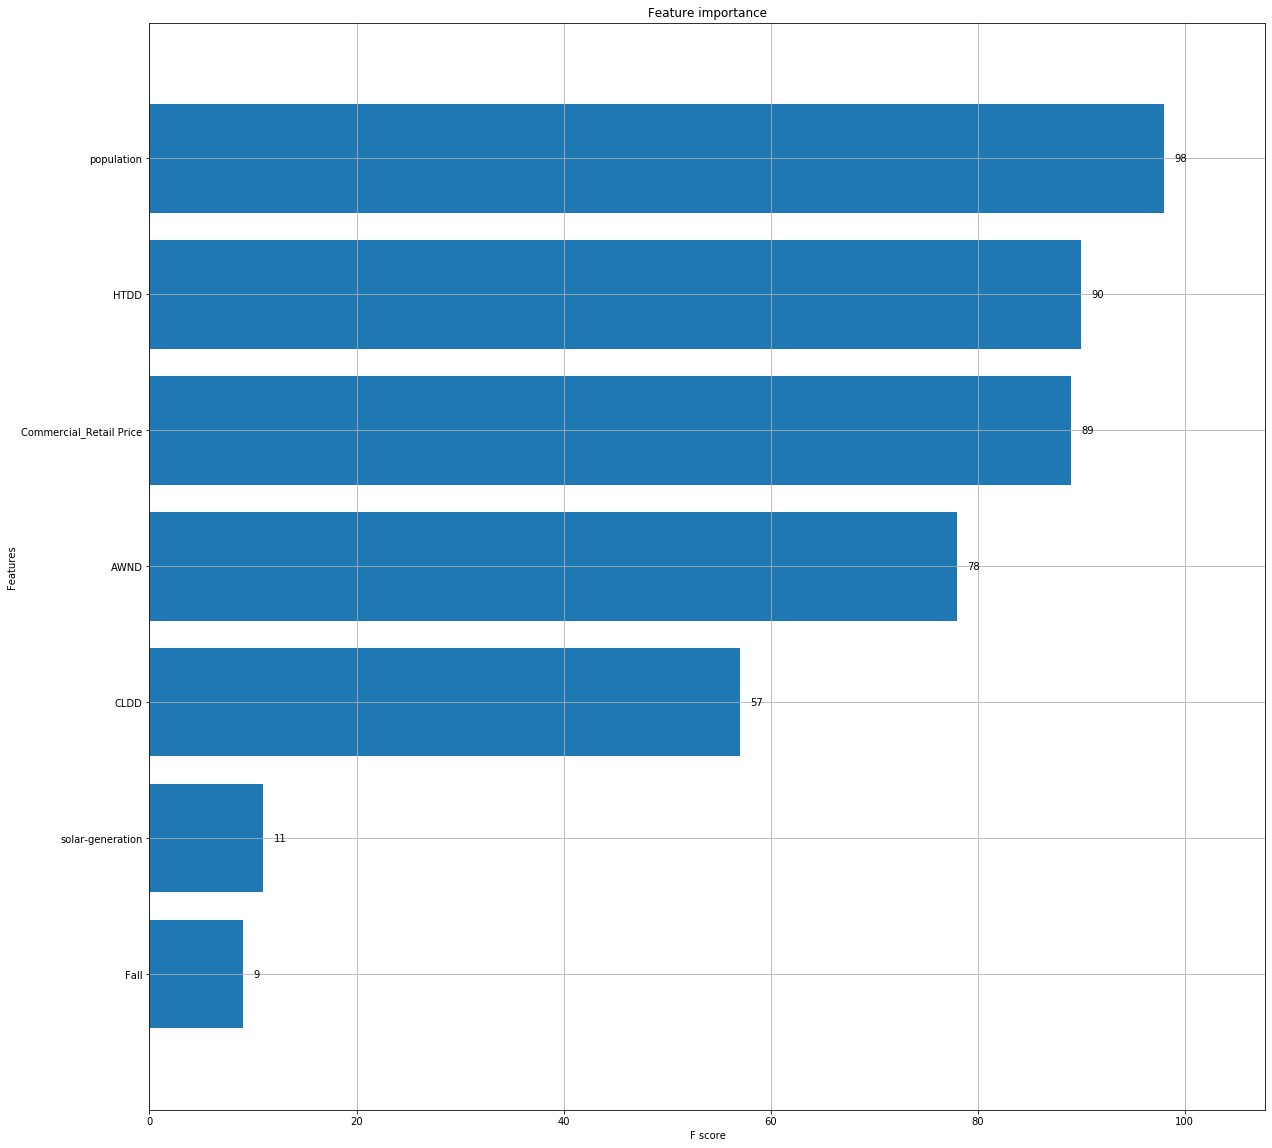

In [24]:
xgbRegressor = XGBRegressor(objective ='reg:squarederror')
xgbRegressor.fit(X_train_c, y_train_c)

fig, ax = plt.subplots(figsize=(20,20))
xgb.plot_importance(xgbRegressor, height=0.8, ax=ax)

### Commercial_Regression_Visualizations

In [25]:
# Correlation Analysis between Y and X's
def correlation_analysis(data, x_vars_list, y_vars_list):
    sns.pairplot(data, x_vars = x_vars_list, y_vars = y_vars_list, size=7, aspect=0.8,kind = 'reg')
#     plt.savefig("pairplot.jpg")
    plt.show()

In [26]:
#Visualize the output
def visualize_graph(df_pred):
    fig, axes = plt.subplots(3,1, figsize=(7,15))
    #Plot the result in line plot
    df_pred.plot.scatter(title="Actual vs. Predict result scatter plot",x='Actual', y='Predicted',ax=axes[0])
    #Plot the result in box plot
    df_pred.plot(title="Actual vs. Predict result box plot",kind='box',ax=axes[1])
    #Plot the result in terms of kernel density estimation
    df_pred.plot(title="Actual vs. Predict result kernel density estimation", kind='density',ax=axes[2]) 

In [27]:
# Visualization
def visualization(y_test, y_pred):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(30,20))
    fig.suptitle('Predicted and Actual plot')
    ax1.plot(range(len(y_pred)),y_pred,'b',label="predict")
    ax1.legend(loc="upper right")
    ax2.plot(range(len(y_test)),y_test,'r',label="actual")
    ax2.legend(loc="upper right")
    ax3.plot(range(len(y_pred)),y_pred,'b',label="predict")
    ax3.plot(range(len(y_test)),y_test,'r',label="test")
    ax3.legend(loc="upper right")
    plt.show()

C:\Users\Maggie\Anaconda3\envs\tensorflow_env\lib\site-packages\seaborn\axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


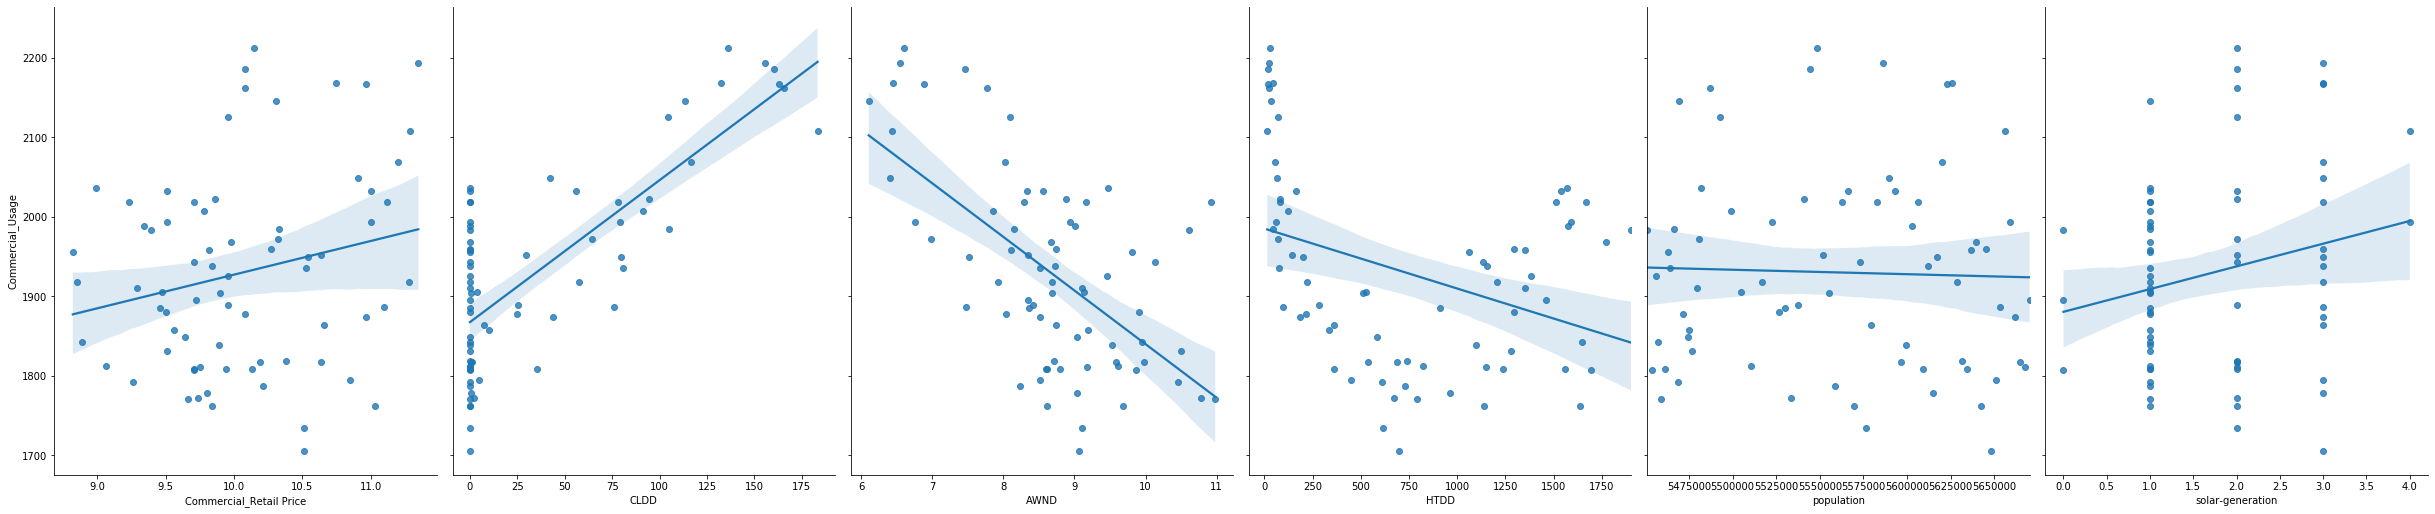

In [28]:
# Correlation Analysis
correlation_analysis(data_MN, commercial_numeric_columns_adj, ['Commercial_Usage'])

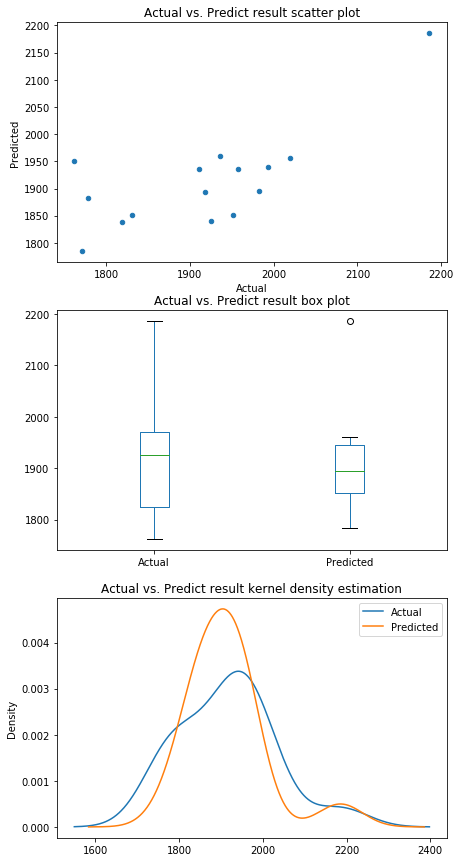

In [29]:
# Visualize Output
visualize_graph(df_pred_c)

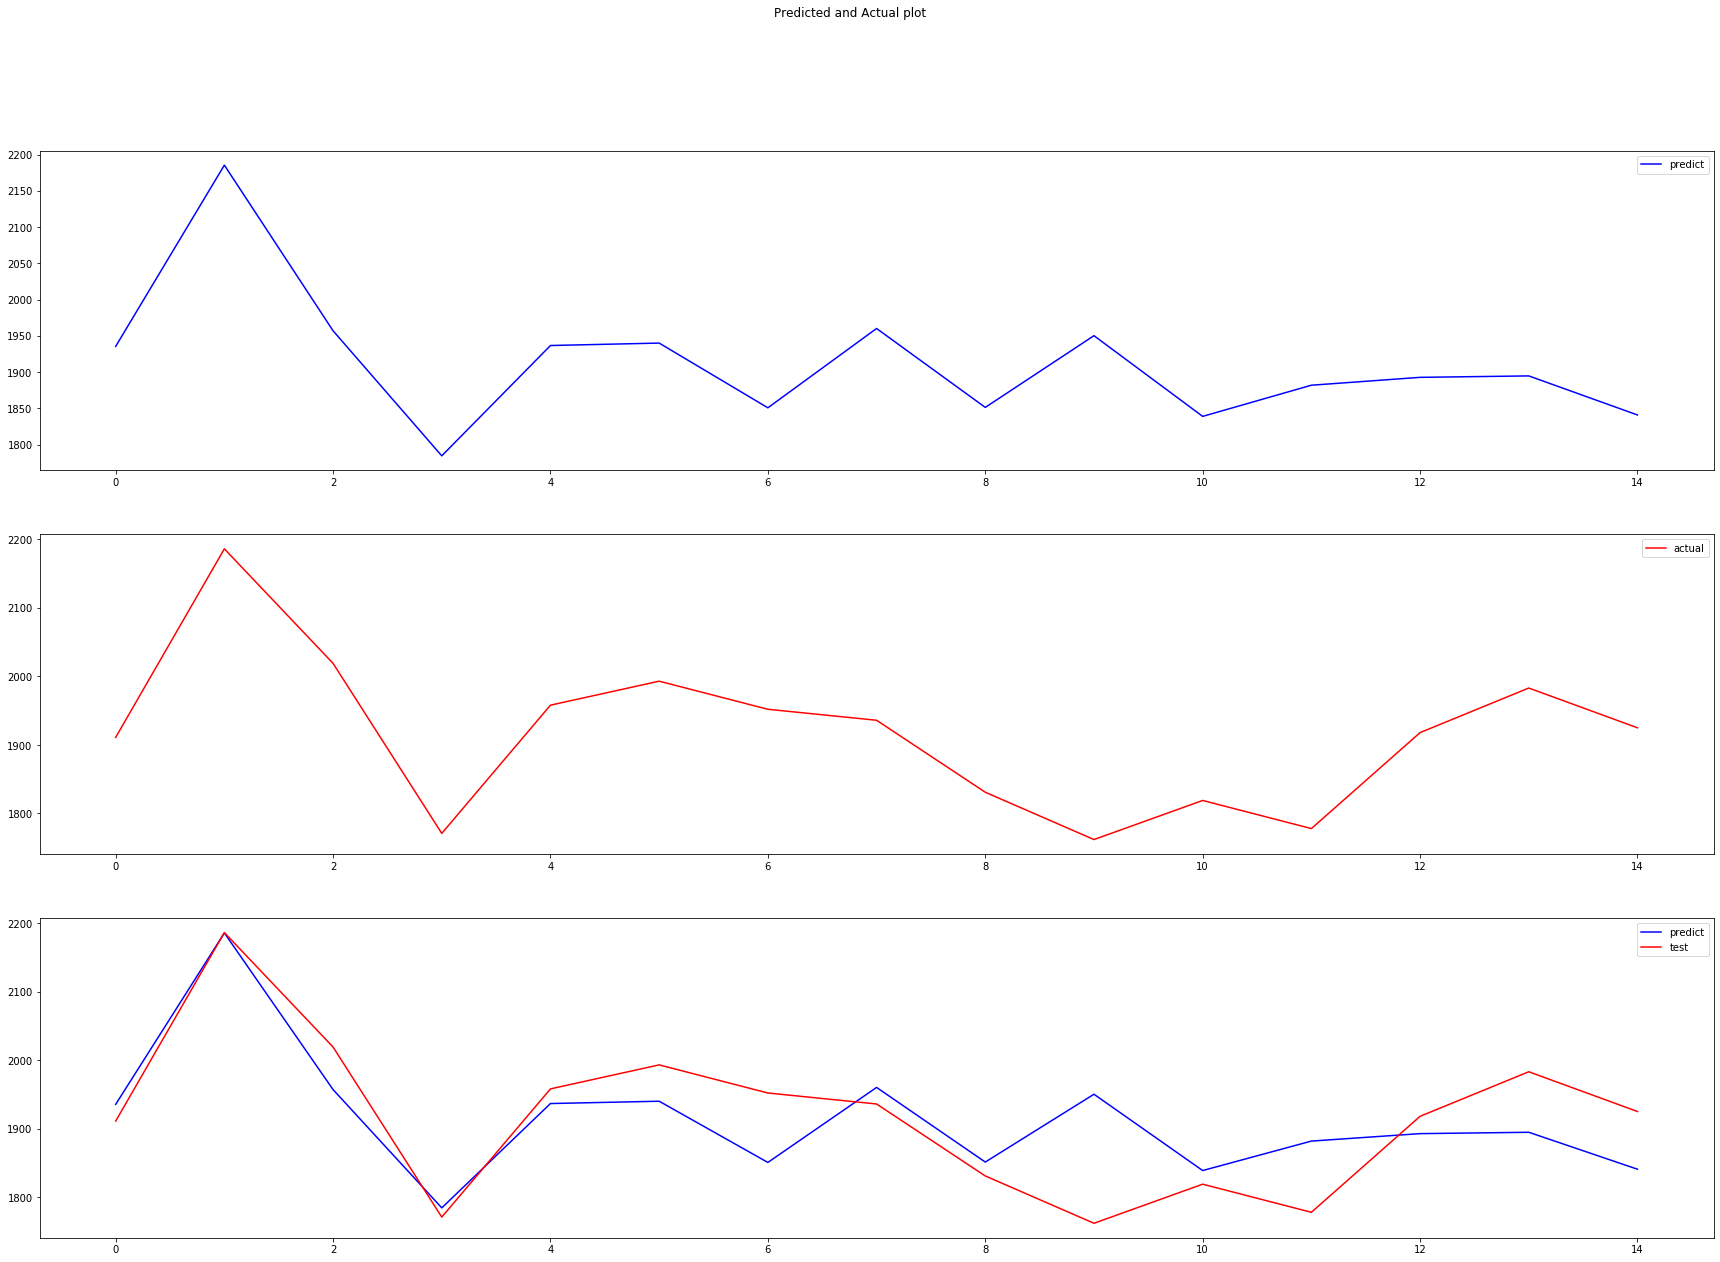

In [30]:
visualization(df_pred_c.Actual, df_pred_c.Predicted)

### Commercial_ANN

In [31]:
features_ANN_c=['Month', 'Commercial_Usage', 'CLDD', 'AWND', 'HTDD', 'population', 'solar-generation','Summer', 'Fall', 'Winter', 'Commercial_Retail Price']
#Spring is the seasonal feature baseline
data_MN_ANN=data[data.MN==1]
data_MN_ANN=data_MN_ANN[features_ANN_c]
data_MN_ANN

,Month,Commercial_Usage,CLDD,AWND,HTDD,population,solar-generation,Summer,Fall,Winter,Commercial_Retail Price
22,1,1983,0.000000,10.618750,1903.577778,5451079,0,0,0,1,9.39
72,2,1807,0.000000,9.868750,1691.444444,5453658,0,0,0,1,9.71
122,3,1925,0.000000,9.462500,1385.320442,5456238,1,0,0,0,9.96
172,4,1771,0.000000,10.981250,793.747253,5458817,1,0,0,0,9.66
222,5,1808,35.298343,8.612500,359.988950,5461397,1,0,0,0,9.71
...,...,...,...,...,...,...,...,...,...,...,...
3372,8,1993,79.011696,6.756250,60.491228,5659105,4,1,0,0,11.00
3422,9,1874,43.847059,8.513333,182.647059,5661887,3,0,1,0,10.97
3472,10,1817,1.315789,9.981250,686.678363,5664669,2,0,1,0,10.19
3522,11,1811,0.000000,9.180000,1150.634286,5667451,2,0,1,0,9.75


In [32]:
train_ANN, test_ANN = train_test_split(data_MN_ANN, test_size=0.2)
X_train_ANN_c, y_train_ANN_c = x_y_split(train_ANN, 'Commercial_Usage', ['Commercial_Usage'])
X_test_ANN_c,y_test_ANN_c = x_y_split(test_ANN, 'Commercial_Usage', ['Commercial_Usage'])

In [33]:
X_train_ANN_c, X_test_ANN_c = minmax_scaler(X_train_ANN_c, X_test_ANN_c, commercial_numeric_columns_adj)
y_train_ANN_c = (y_train_ANN_c - min(y_train_ANN_c))/(max(y_train_ANN_c) - min(y_train_ANN_c))

In [34]:
# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 15, kernel_initializer = 'uniform', activation = 'relu', input_dim = 10))

# Adding the second hidden layer
classifier.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae'])

# Fitting the ANN to the training set
classifier.fit(X_train_ANN_c, y_train_ANN_c, validation_split = 0.2, batch_size = 10, epochs = 1200)

Train on 45 samples, validate on 12 samples
Epoch 1/1200
45/45 [==============================] - 1s 23ms/step - loss: 0.0575 - mae: 0.1918 - val_loss: 0.0447 - val_mae: 0.1806
Epoch 2/1200
45/45 [==============================] - 0s 620us/step - loss: 0.0574 - mae: 0.1917 - val_loss: 0.0445 - val_mae: 0.1800
Epoch 3/1200
45/45 [==============================] - 0s 621us/step - loss: 0.0574 - mae: 0.1916 - val_loss: 0.0442 - val_mae: 0.1793
Epoch 4/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0572 - mae: 0.1914 - val_loss: 0.0440 - val_mae: 0.1788
Epoch 5/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0572 - mae: 0.1913 - val_loss: 0.0438 - val_mae: 0.1782
Epoch 6/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0571 - mae: 0.1913 - val_loss: 0.0435 - val_mae: 0.1775
Epoch 7/1200
45/45 [==============================] - 0s 487us/step - loss: 0.0570 - mae: 0.1911 - val_loss: 0.0432 - val_mae: 0.1768
Epoch 8/1200
45/45 

45/45 [==============================] - 0s 488us/step - loss: 0.0418 - mae: 0.1635 - val_loss: 0.0266 - val_mae: 0.1388
Epoch 62/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0414 - mae: 0.1628 - val_loss: 0.0266 - val_mae: 0.1386
Epoch 63/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0410 - mae: 0.1621 - val_loss: 0.0265 - val_mae: 0.1382
Epoch 64/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0406 - mae: 0.1610 - val_loss: 0.0265 - val_mae: 0.1381
Epoch 65/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0402 - mae: 0.1598 - val_loss: 0.0266 - val_mae: 0.1380
Epoch 66/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0397 - mae: 0.1587 - val_loss: 0.0266 - val_mae: 0.1380
Epoch 67/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0393 - mae: 0.1578 - val_loss: 0.0266 - val_mae: 0.1379
Epoch 68/1200
45/45 [==============================] - 0s 510us/step 

45/45 [==============================] - 0s 510us/step - loss: 0.0184 - mae: 0.1135 - val_loss: 0.0298 - val_mae: 0.1422
Epoch 122/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0183 - mae: 0.1131 - val_loss: 0.0299 - val_mae: 0.1413
Epoch 123/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0181 - mae: 0.1121 - val_loss: 0.0302 - val_mae: 0.1404
Epoch 124/1200
45/45 [==============================] - 0s 576us/step - loss: 0.0184 - mae: 0.1133 - val_loss: 0.0304 - val_mae: 0.1364
Epoch 125/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0179 - mae: 0.1118 - val_loss: 0.0301 - val_mae: 0.1398
Epoch 126/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0177 - mae: 0.1108 - val_loss: 0.0301 - val_mae: 0.1413
Epoch 127/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0176 - mae: 0.1107 - val_loss: 0.0301 - val_mae: 0.1409
Epoch 128/1200
45/45 [==============================] - 0s 554u

45/45 [==============================] - 0s 465us/step - loss: 0.0138 - mae: 0.0969 - val_loss: 0.0288 - val_mae: 0.1387
Epoch 182/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0138 - mae: 0.0968 - val_loss: 0.0286 - val_mae: 0.1405
Epoch 183/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0138 - mae: 0.0967 - val_loss: 0.0283 - val_mae: 0.1392
Epoch 184/1200
45/45 [==============================] - 0s 511us/step - loss: 0.0137 - mae: 0.0967 - val_loss: 0.0284 - val_mae: 0.1369
Epoch 185/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0137 - mae: 0.0970 - val_loss: 0.0283 - val_mae: 0.1380
Epoch 186/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0137 - mae: 0.0966 - val_loss: 0.0284 - val_mae: 0.1384
Epoch 187/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0136 - mae: 0.0961 - val_loss: 0.0285 - val_mae: 0.1394
Epoch 188/1200
45/45 [==============================] - 0s 443u

Epoch 241/1200
45/45 [==============================] - 0s 687us/step - loss: 0.0125 - mae: 0.0890 - val_loss: 0.0268 - val_mae: 0.1379
Epoch 242/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0125 - mae: 0.0890 - val_loss: 0.0269 - val_mae: 0.1355
Epoch 243/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0124 - mae: 0.0890 - val_loss: 0.0270 - val_mae: 0.1349
Epoch 244/1200
45/45 [==============================] - 0s 643us/step - loss: 0.0127 - mae: 0.0899 - val_loss: 0.0268 - val_mae: 0.1363
Epoch 245/1200
45/45 [==============================] - 0s 576us/step - loss: 0.0124 - mae: 0.0891 - val_loss: 0.0271 - val_mae: 0.1340
Epoch 246/1200
45/45 [==============================] - 0s 709us/step - loss: 0.0124 - mae: 0.0886 - val_loss: 0.0271 - val_mae: 0.1350
Epoch 247/1200
45/45 [==============================] - 0s 665us/step - loss: 0.0125 - mae: 0.0889 - val_loss: 0.0269 - val_mae: 0.1368
Epoch 248/1200
45/45 [==========================

Epoch 301/1200
45/45 [==============================] - 0s 421us/step - loss: 0.0117 - mae: 0.0850 - val_loss: 0.0273 - val_mae: 0.1387
Epoch 302/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0118 - mae: 0.0854 - val_loss: 0.0273 - val_mae: 0.1395
Epoch 303/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0118 - mae: 0.0856 - val_loss: 0.0273 - val_mae: 0.1385
Epoch 304/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0118 - mae: 0.0853 - val_loss: 0.0272 - val_mae: 0.1376
Epoch 305/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0117 - mae: 0.0849 - val_loss: 0.0273 - val_mae: 0.1365
Epoch 306/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0119 - mae: 0.0855 - val_loss: 0.0275 - val_mae: 0.1348
Epoch 307/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0118 - mae: 0.0848 - val_loss: 0.0272 - val_mae: 0.1385
Epoch 308/1200
45/45 [==========================

Epoch 361/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0115 - mae: 0.0852 - val_loss: 0.0277 - val_mae: 0.1429
Epoch 362/1200
45/45 [==============================] - 0s 487us/step - loss: 0.0115 - mae: 0.0856 - val_loss: 0.0278 - val_mae: 0.1427
Epoch 363/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0115 - mae: 0.0848 - val_loss: 0.0280 - val_mae: 0.1397
Epoch 364/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0114 - mae: 0.0836 - val_loss: 0.0281 - val_mae: 0.1402
Epoch 365/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0114 - mae: 0.0840 - val_loss: 0.0281 - val_mae: 0.1412
Epoch 366/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0114 - mae: 0.0840 - val_loss: 0.0283 - val_mae: 0.1401
Epoch 367/1200
45/45 [==============================] - ETA: 0s - loss: 0.0106 - mae: 0.081 - 0s 443us/step - loss: 0.0114 - mae: 0.0833 - val_loss: 0.0284 - val_mae: 0.1386
Epoch 368/

Epoch 421/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0112 - mae: 0.0833 - val_loss: 0.0285 - val_mae: 0.1423
Epoch 422/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0112 - mae: 0.0838 - val_loss: 0.0285 - val_mae: 0.1428
Epoch 423/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0112 - mae: 0.0835 - val_loss: 0.0286 - val_mae: 0.1408
Epoch 424/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0111 - mae: 0.0826 - val_loss: 0.0285 - val_mae: 0.1427
Epoch 425/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0112 - mae: 0.0845 - val_loss: 0.0285 - val_mae: 0.1456
Epoch 426/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0114 - mae: 0.0862 - val_loss: 0.0286 - val_mae: 0.1454
Epoch 427/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0110 - mae: 0.0835 - val_loss: 0.0290 - val_mae: 0.1395
Epoch 428/1200
45/45 [==========================

Epoch 481/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0110 - mae: 0.0833 - val_loss: 0.0292 - val_mae: 0.1434
Epoch 482/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0111 - mae: 0.0837 - val_loss: 0.0292 - val_mae: 0.1458
Epoch 483/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0110 - mae: 0.0835 - val_loss: 0.0293 - val_mae: 0.1425
Epoch 484/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0109 - mae: 0.0820 - val_loss: 0.0296 - val_mae: 0.1419
Epoch 485/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0110 - mae: 0.0814 - val_loss: 0.0296 - val_mae: 0.1426
Epoch 486/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0109 - mae: 0.0818 - val_loss: 0.0295 - val_mae: 0.1446
Epoch 487/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0110 - mae: 0.0836 - val_loss: 0.0294 - val_mae: 0.1463
Epoch 488/1200
45/45 [==========================

Epoch 541/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0108 - mae: 0.0820 - val_loss: 0.0301 - val_mae: 0.1462
Epoch 542/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0110 - mae: 0.0825 - val_loss: 0.0302 - val_mae: 0.1454
Epoch 543/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0108 - mae: 0.0821 - val_loss: 0.0301 - val_mae: 0.1467
Epoch 544/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0108 - mae: 0.0826 - val_loss: 0.0301 - val_mae: 0.1467
Epoch 545/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0110 - mae: 0.0831 - val_loss: 0.0301 - val_mae: 0.1455
Epoch 546/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0108 - mae: 0.0818 - val_loss: 0.0302 - val_mae: 0.1460
Epoch 547/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0108 - mae: 0.0823 - val_loss: 0.0302 - val_mae: 0.1469
Epoch 548/1200
45/45 [==========================

Epoch 601/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0107 - mae: 0.0810 - val_loss: 0.0309 - val_mae: 0.1481
Epoch 602/1200
45/45 [==============================] - 0s 466us/step - loss: 0.0107 - mae: 0.0815 - val_loss: 0.0309 - val_mae: 0.1490
Epoch 603/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0106 - mae: 0.0817 - val_loss: 0.0309 - val_mae: 0.1489
Epoch 604/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0106 - mae: 0.0815 - val_loss: 0.0309 - val_mae: 0.1492
Epoch 605/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0106 - mae: 0.0817 - val_loss: 0.0311 - val_mae: 0.1491
Epoch 606/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0107 - mae: 0.0821 - val_loss: 0.0311 - val_mae: 0.1494
Epoch 607/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0107 - mae: 0.0817 - val_loss: 0.0315 - val_mae: 0.1480
Epoch 608/1200
45/45 [==========================

45/45 [==============================] - 0s 465us/step - loss: 0.0105 - mae: 0.0806 - val_loss: 0.0321 - val_mae: 0.1521
Epoch 662/1200
45/45 [==============================] - 0s 487us/step - loss: 0.0105 - mae: 0.0820 - val_loss: 0.0321 - val_mae: 0.1531
Epoch 663/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0106 - mae: 0.0828 - val_loss: 0.0322 - val_mae: 0.1525
Epoch 664/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0105 - mae: 0.0816 - val_loss: 0.0322 - val_mae: 0.1521
Epoch 665/1200
45/45 [==============================] - 0s 466us/step - loss: 0.0105 - mae: 0.0811 - val_loss: 0.0322 - val_mae: 0.1519
Epoch 666/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0105 - mae: 0.0811 - val_loss: 0.0322 - val_mae: 0.1517
Epoch 667/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0105 - mae: 0.0805 - val_loss: 0.0322 - val_mae: 0.1512
Epoch 668/1200
45/45 [==============================] - 0s 465u

45/45 [==============================] - 0s 532us/step - loss: 0.0104 - mae: 0.0800 - val_loss: 0.0327 - val_mae: 0.1524
Epoch 722/1200
45/45 [==============================] - 0s 598us/step - loss: 0.0105 - mae: 0.0799 - val_loss: 0.0327 - val_mae: 0.1526
Epoch 723/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0104 - mae: 0.0804 - val_loss: 0.0327 - val_mae: 0.1535
Epoch 724/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0104 - mae: 0.0806 - val_loss: 0.0327 - val_mae: 0.1537
Epoch 725/1200
45/45 [==============================] - 0s 487us/step - loss: 0.0103 - mae: 0.0807 - val_loss: 0.0327 - val_mae: 0.1544
Epoch 726/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0104 - mae: 0.0818 - val_loss: 0.0327 - val_mae: 0.1548
Epoch 727/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0105 - mae: 0.0824 - val_loss: 0.0328 - val_mae: 0.1547
Epoch 728/1200
45/45 [==============================] - 0s 554u

45/45 [==============================] - 0s 510us/step - loss: 0.0102 - mae: 0.0802 - val_loss: 0.0336 - val_mae: 0.1548
Epoch 782/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0104 - mae: 0.0805 - val_loss: 0.0336 - val_mae: 0.1547
Epoch 783/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0108 - mae: 0.0827 - val_loss: 0.0338 - val_mae: 0.1576
Epoch 784/1200
45/45 [==============================] - 0s 421us/step - loss: 0.0104 - mae: 0.0832 - val_loss: 0.0337 - val_mae: 0.1569
Epoch 785/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0102 - mae: 0.0814 - val_loss: 0.0337 - val_mae: 0.1556
Epoch 786/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0102 - mae: 0.0801 - val_loss: 0.0339 - val_mae: 0.1551
Epoch 787/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0103 - mae: 0.0797 - val_loss: 0.0339 - val_mae: 0.1549
Epoch 788/1200
45/45 [==============================] - 0s 598u

45/45 [==============================] - 0s 465us/step - loss: 0.0101 - mae: 0.0798 - val_loss: 0.0349 - val_mae: 0.1588
Epoch 842/1200
45/45 [==============================] - 0s 487us/step - loss: 0.0103 - mae: 0.0823 - val_loss: 0.0349 - val_mae: 0.1596
Epoch 843/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0103 - mae: 0.0827 - val_loss: 0.0349 - val_mae: 0.1591
Epoch 844/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0103 - mae: 0.0814 - val_loss: 0.0349 - val_mae: 0.1567
Epoch 845/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0102 - mae: 0.0795 - val_loss: 0.0349 - val_mae: 0.1564
Epoch 846/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0102 - mae: 0.0795 - val_loss: 0.0348 - val_mae: 0.1575
Epoch 847/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0101 - mae: 0.0803 - val_loss: 0.0349 - val_mae: 0.1593
Epoch 848/1200
45/45 [==============================] - 0s 443u

45/45 [==============================] - 0s 488us/step - loss: 0.0101 - mae: 0.0808 - val_loss: 0.0353 - val_mae: 0.1590
Epoch 902/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0101 - mae: 0.0807 - val_loss: 0.0353 - val_mae: 0.1587
Epoch 903/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0101 - mae: 0.0805 - val_loss: 0.0353 - val_mae: 0.1584
Epoch 904/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0101 - mae: 0.0802 - val_loss: 0.0353 - val_mae: 0.1582
Epoch 905/1200
45/45 [==============================] - 0s 421us/step - loss: 0.0101 - mae: 0.0797 - val_loss: 0.0354 - val_mae: 0.1576
Epoch 906/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0102 - mae: 0.0796 - val_loss: 0.0354 - val_mae: 0.1576
Epoch 907/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0101 - mae: 0.0800 - val_loss: 0.0354 - val_mae: 0.1593
Epoch 908/1200
45/45 [==============================] - 0s 443u

45/45 [==============================] - 0s 487us/step - loss: 0.0100 - mae: 0.0797 - val_loss: 0.0363 - val_mae: 0.1609
Epoch 962/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0102 - mae: 0.0817 - val_loss: 0.0364 - val_mae: 0.1617
Epoch 963/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0101 - mae: 0.0819 - val_loss: 0.0363 - val_mae: 0.1603
Epoch 964/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0100 - mae: 0.0802 - val_loss: 0.0363 - val_mae: 0.1594
Epoch 965/1200
45/45 [==============================] - ETA: 0s - loss: 0.0057 - mae: 0.061 - 0s 488us/step - loss: 0.0101 - mae: 0.0794 - val_loss: 0.0365 - val_mae: 0.1581
Epoch 966/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0101 - mae: 0.0791 - val_loss: 0.0363 - val_mae: 0.1588
Epoch 967/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0101 - mae: 0.0798 - val_loss: 0.0363 - val_mae: 0.1600
Epoch 968/1200
45/45 [===

45/45 [==============================] - 0s 465us/step - loss: 0.0101 - mae: 0.0801 - val_loss: 0.0367 - val_mae: 0.1602
Epoch 1021/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0100 - mae: 0.0796 - val_loss: 0.0367 - val_mae: 0.1600
Epoch 1022/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0101 - mae: 0.0803 - val_loss: 0.0367 - val_mae: 0.1607
Epoch 1023/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0100 - mae: 0.0796 - val_loss: 0.0368 - val_mae: 0.1597
Epoch 1024/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0100 - mae: 0.0791 - val_loss: 0.0368 - val_mae: 0.1601
Epoch 1025/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0101 - mae: 0.0798 - val_loss: 0.0368 - val_mae: 0.1605
Epoch 1026/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0101 - mae: 0.0808 - val_loss: 0.0368 - val_mae: 0.1618
Epoch 1027/1200
45/45 [==============================] - 

Epoch 1080/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0100 - mae: 0.0797 - val_loss: 0.0374 - val_mae: 0.1614
Epoch 1081/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0100 - mae: 0.0801 - val_loss: 0.0374 - val_mae: 0.1620
Epoch 1082/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0100 - mae: 0.0806 - val_loss: 0.0375 - val_mae: 0.1623
Epoch 1083/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0100 - mae: 0.0807 - val_loss: 0.0374 - val_mae: 0.1622
Epoch 1084/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0100 - mae: 0.0807 - val_loss: 0.0374 - val_mae: 0.1618
Epoch 1085/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0100 - mae: 0.0805 - val_loss: 0.0373 - val_mae: 0.1613
Epoch 1086/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0100 - mae: 0.0801 - val_loss: 0.0374 - val_mae: 0.1609
Epoch 1087/1200
45/45 [==================

Epoch 1140/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0099 - mae: 0.0798 - val_loss: 0.0378 - val_mae: 0.1607
Epoch 1141/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0100 - mae: 0.0793 - val_loss: 0.0377 - val_mae: 0.1606
Epoch 1142/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0101 - mae: 0.0803 - val_loss: 0.0377 - val_mae: 0.1616
Epoch 1143/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0100 - mae: 0.0801 - val_loss: 0.0378 - val_mae: 0.1612
Epoch 1144/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0100 - mae: 0.0804 - val_loss: 0.0378 - val_mae: 0.1619
Epoch 1145/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0100 - mae: 0.0803 - val_loss: 0.0378 - val_mae: 0.1619
Epoch 1146/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0100 - mae: 0.0804 - val_loss: 0.0378 - val_mae: 0.1616
Epoch 1147/1200
45/45 [==================

Epoch 1200/1200
45/45 [==============================] - 0s 576us/step - loss: 0.0099 - mae: 0.0802 - val_loss: 0.0383 - val_mae: 0.1635


In [35]:
# Predicting the Test set results
predictions_ANN_c = classifier.predict(X_test_ANN_c)
# Scale y back 
predictions_ANN_c = (predictions_ANN_c * (max(y_test_ANN_c) - min(y_test_ANN_c))) + min(y_test_ANN_c)
predictions_ANN_c = predictions_ANN_c.reshape(-1)
df_pred_ANN_c = pd.DataFrame({'Actual': y_test_ANN_c, 'Predicted': predictions_ANN_c})

In [36]:
df_pred_ANN_c

,Actual,Predicted
2022,1864,1864.025269
2372,1989,1986.618652
1372,1772,1884.028076
3222,1795,1859.030518
2122,2193,2089.271973
2572,1778,1935.649048
2722,2167,2122.298340
772,1792,1904.583252
2322,1839,1899.446289
1922,1943,1900.244141


In [37]:
evaluate_performances(y_test_ANN_c, predictions_ANN_c)

Performance Evaluation
Mean Absolute Error: 57.88461100260417
Mean Squared Error: 5276.630399098993
Root Mean Squared Error: 72.64041849479526


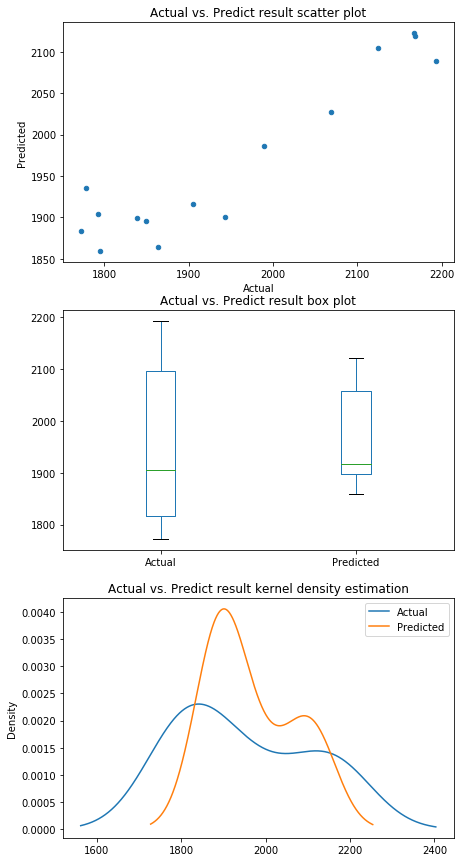

In [38]:
visualize_graph(df_pred_ANN_c)

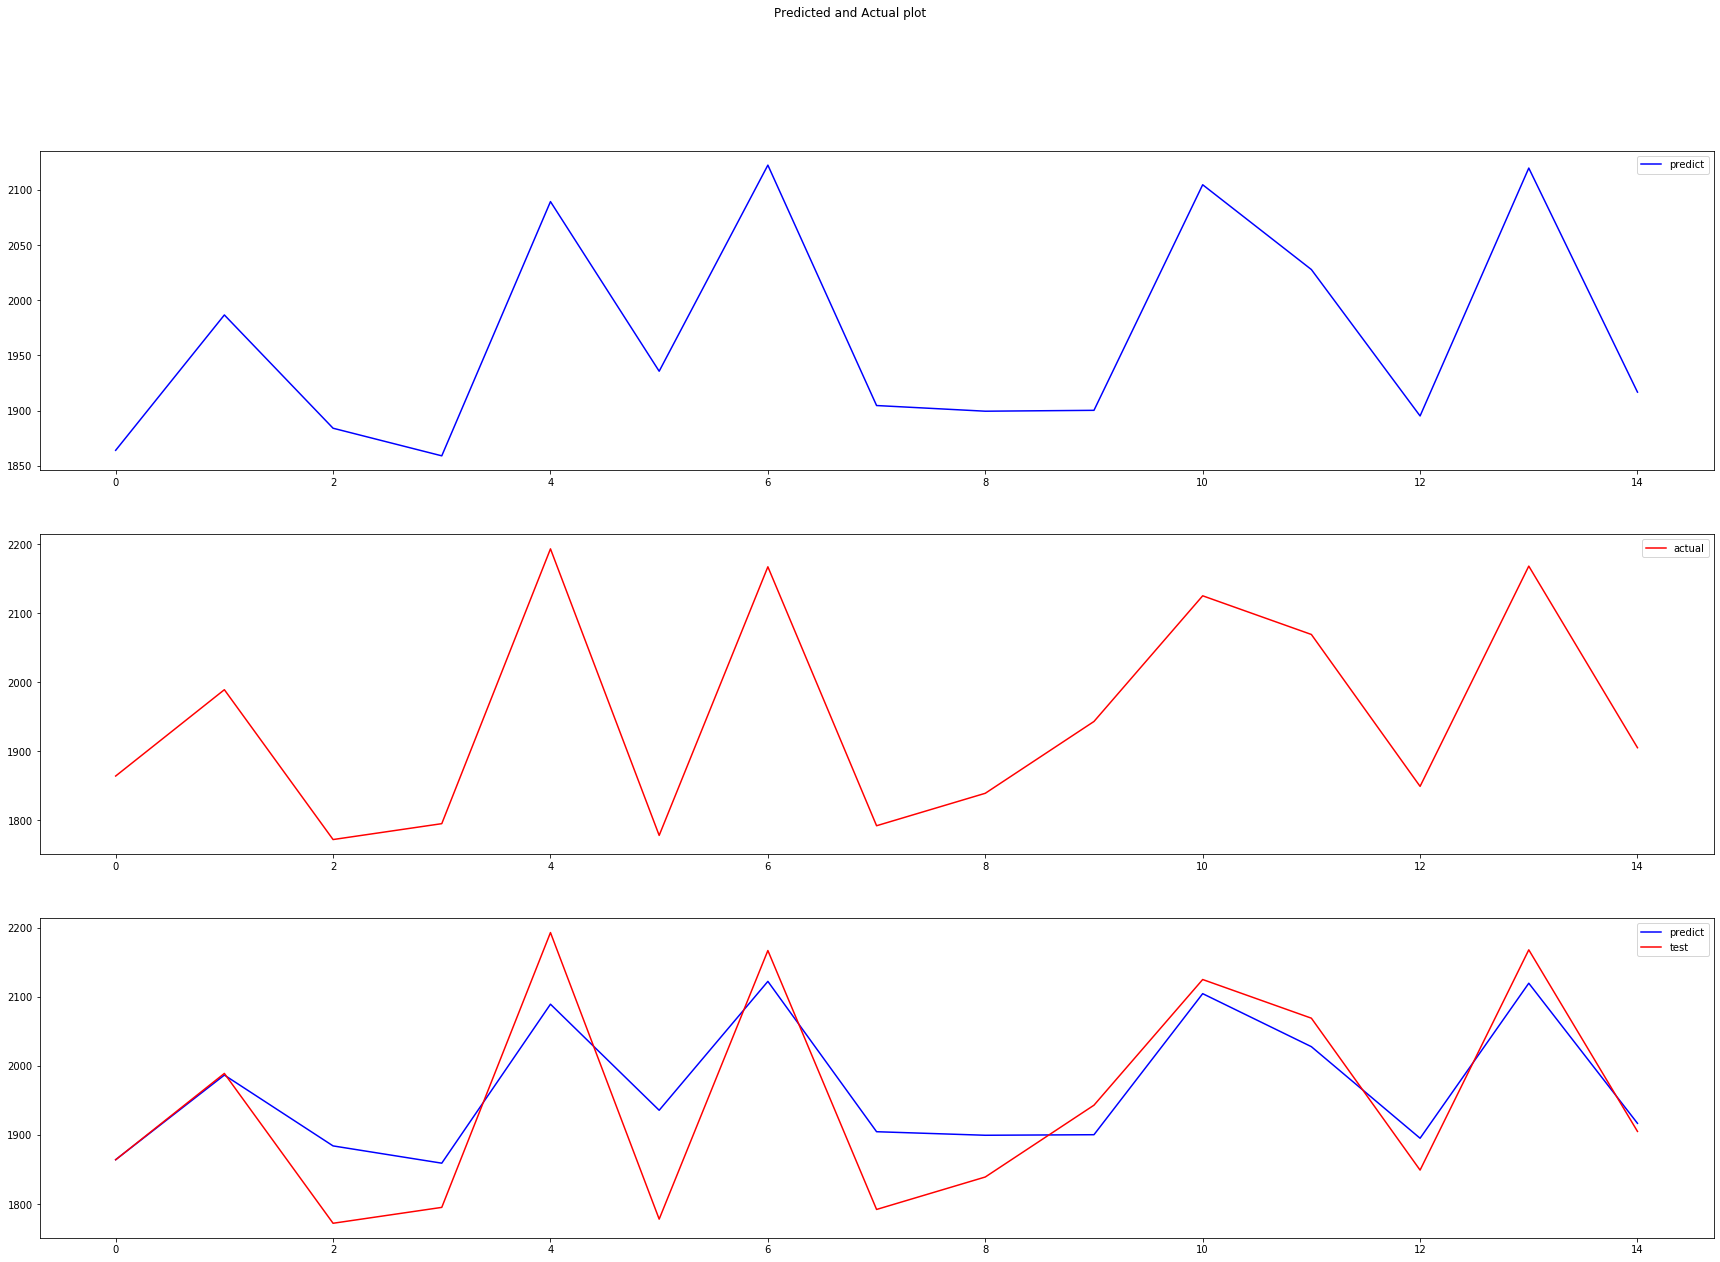

In [39]:
visualization(df_pred_ANN_c.Actual, df_pred_ANN_c.Predicted)

## Industrial Consumption Forecast

In [40]:
df_pred_i=sm_regression(X_train_i, y_train_i, X_test_i, y_test_i)

                            OLS Regression Results                            
Dep. Variable:       Industrial_Usage   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     5.557
Date:                Wed, 22 Jul 2020   Prob (F-statistic):           3.37e-05
Time:                        10:50:28   Log-Likelihood:                -327.40
No. Observations:                  57   AIC:                             674.8
Df Residuals:                      47   BIC:                             695.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    1

In [41]:
df_pred_i

,Actual,Predicted
572,2010,1891.464664
1522,1891,1899.683250
2072,1883,1814.626649
172,1804,1810.129558
2972,1860,1737.698063
1222,1736,1748.069435
1622,1838,1860.693681
272,1883,1912.367489
522,1892,1904.078698
3072,1555,1683.671499


In [42]:
evaluate_performances(df_pred_i['Actual'], df_pred_i['Predicted'])

Performance Evaluation
Mean Absolute Error: 69.85717245975756
Mean Squared Error: 7158.343225086223
Root Mean Squared Error: 84.60699276706521


# Industrial Feature Importance

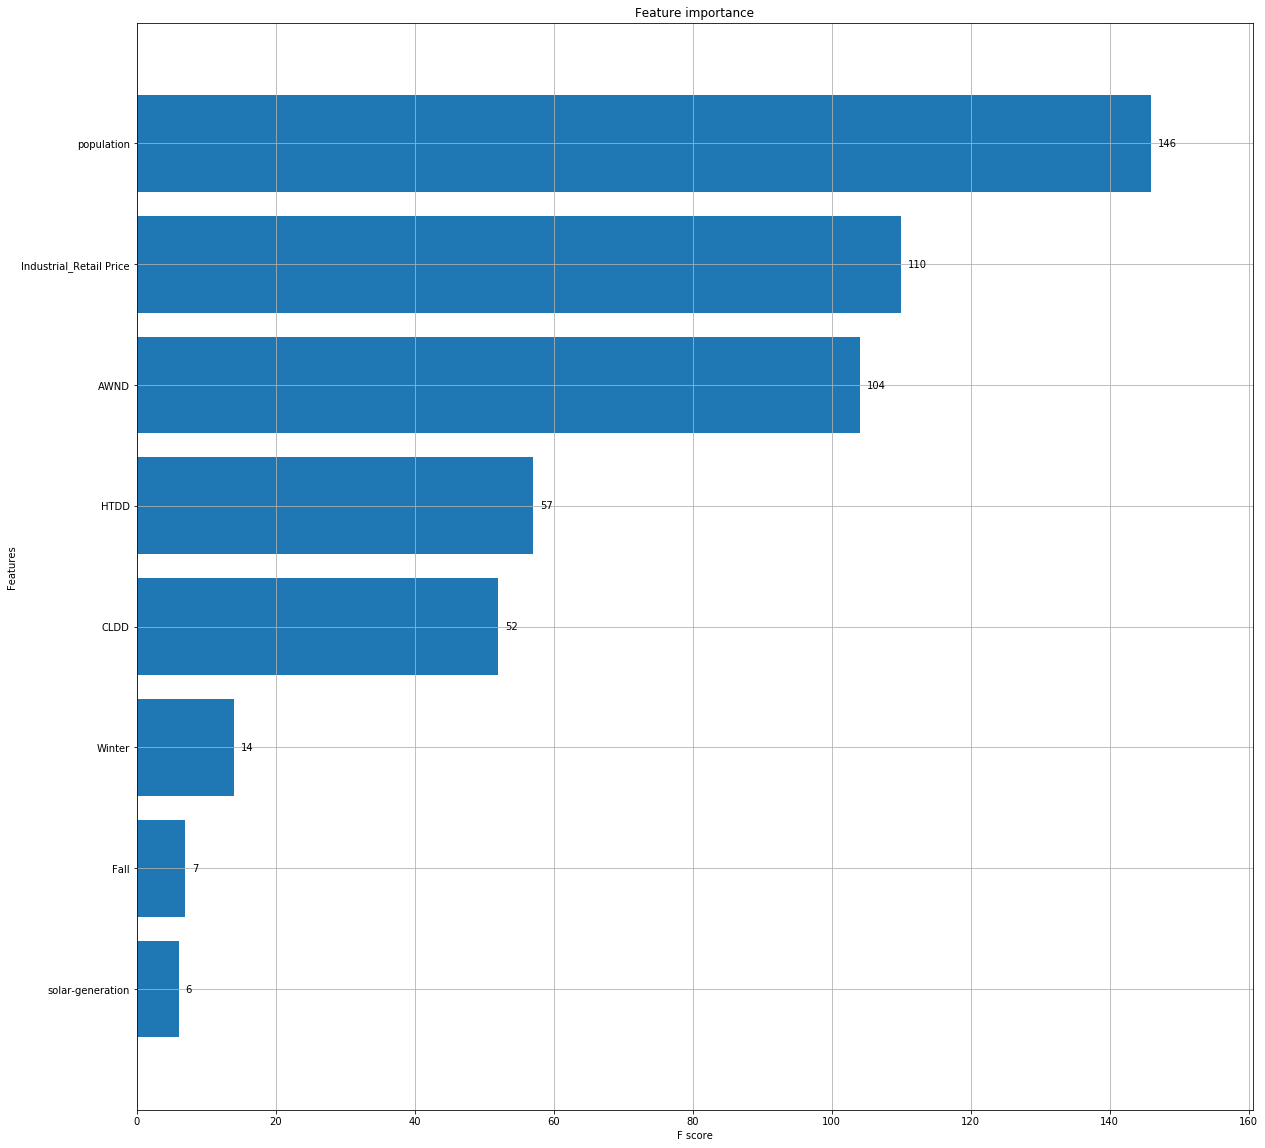

In [43]:
xgbRegressor = XGBRegressor(objective ='reg:squarederror')
xgbRegressor.fit(X_train_i, y_train_i)

fig, ax = plt.subplots(figsize=(20,20))
xgb.plot_importance(xgbRegressor, height=0.8, ax=ax)

C:\Users\Maggie\Anaconda3\envs\tensorflow_env\lib\site-packages\seaborn\axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


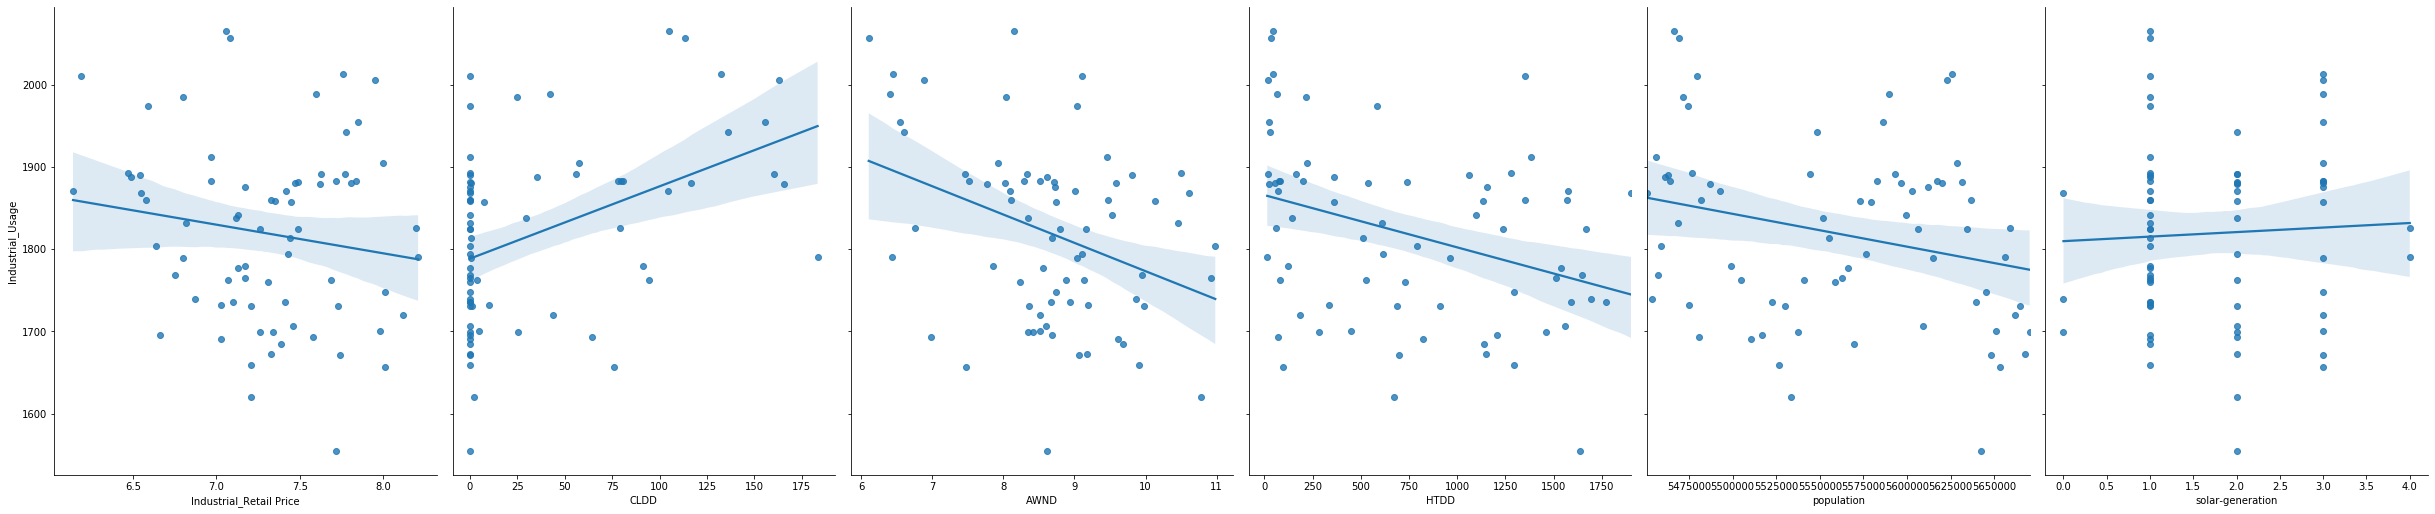

In [44]:
# Correlation Analysis
correlation_analysis(data_MN, industrial_numeric_columns_adj, ['Industrial_Usage'])

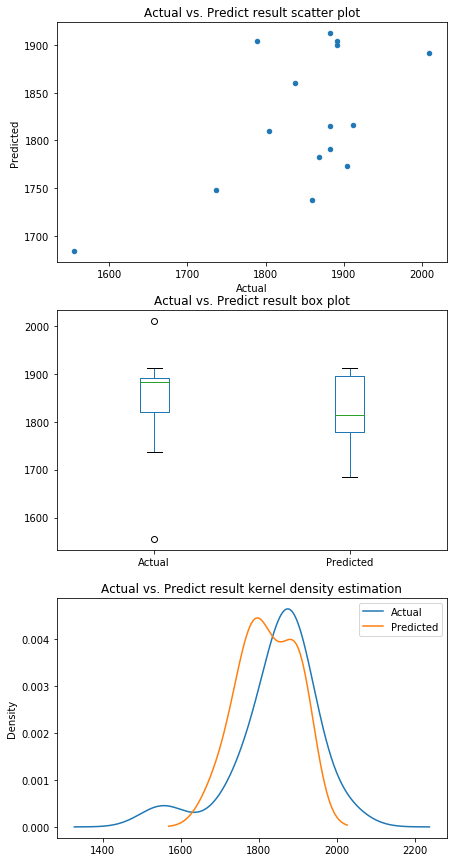

In [45]:
visualize_graph(df_pred_i)

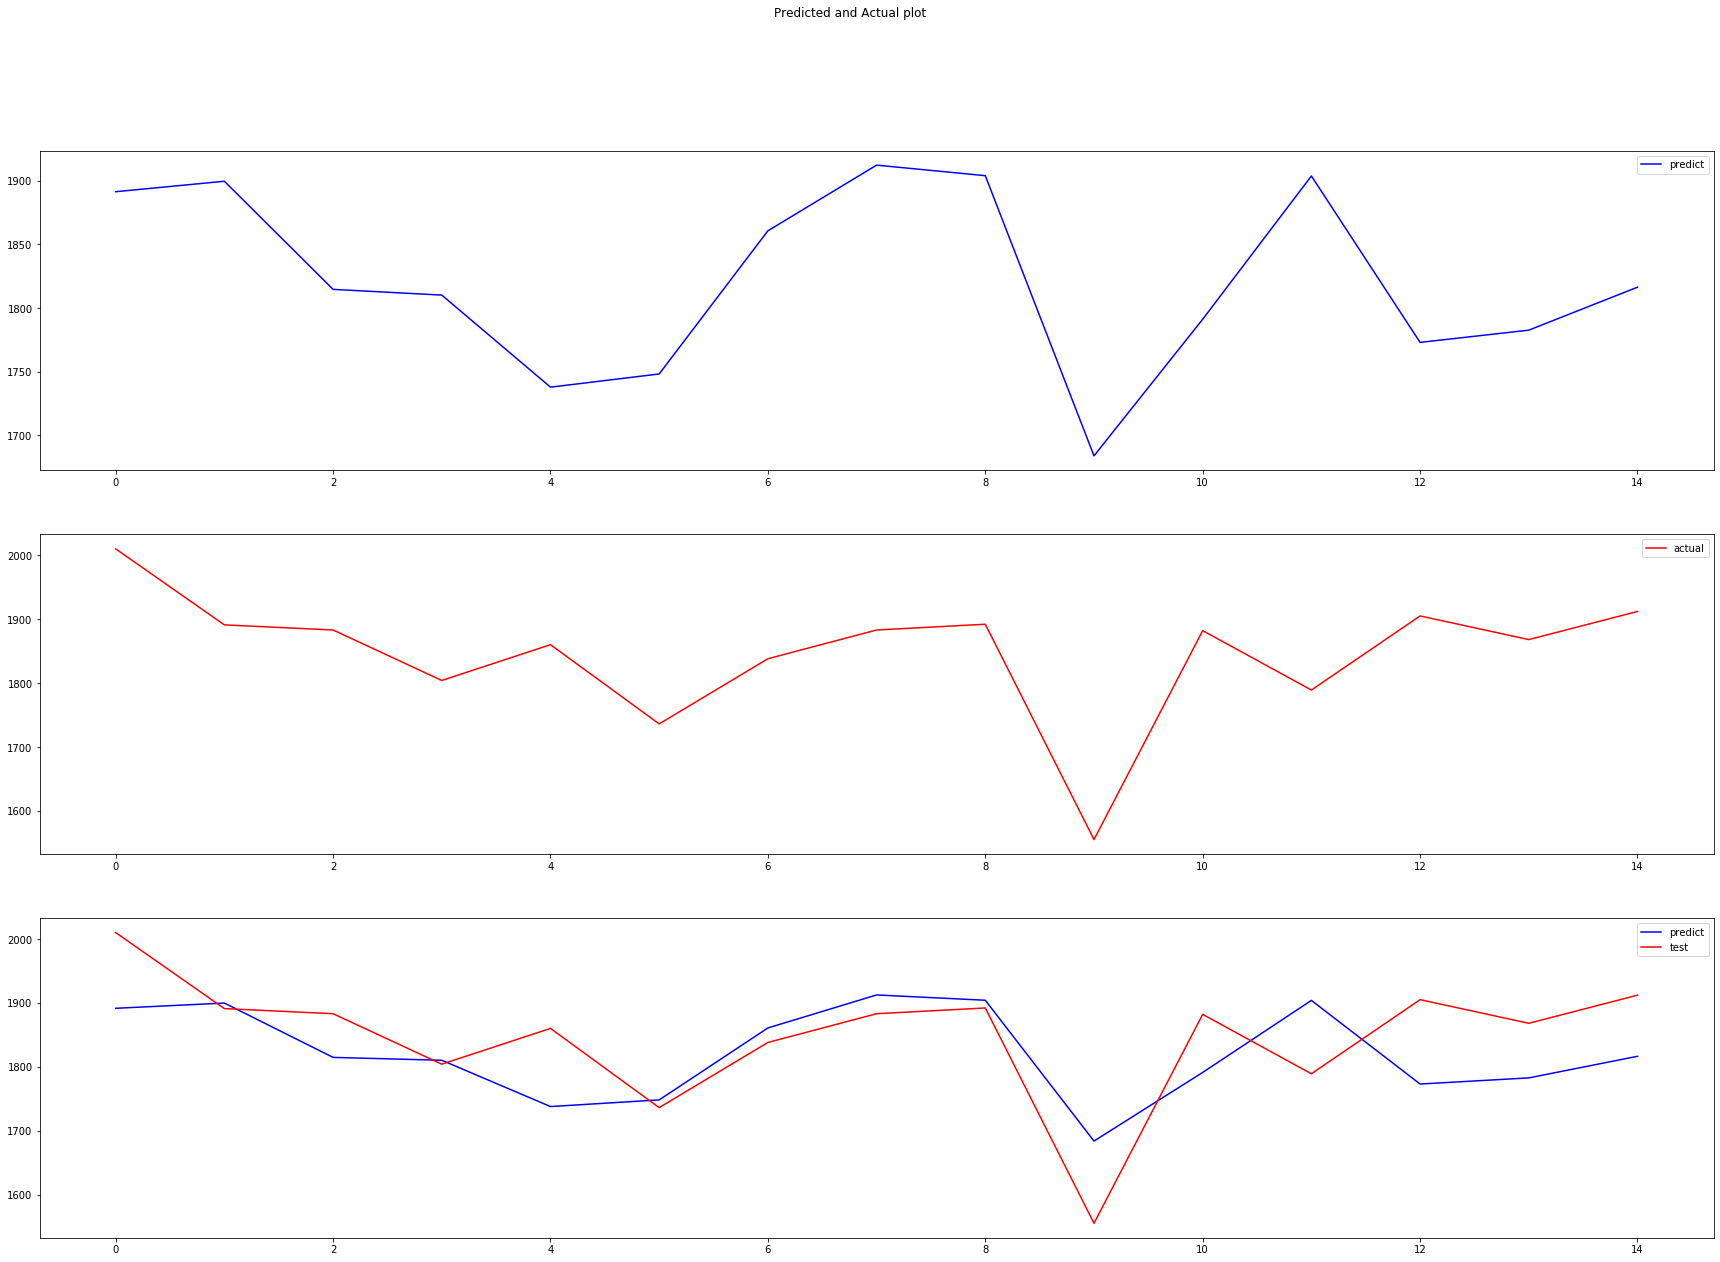

In [46]:
visualization(df_pred_i.Actual, df_pred_i.Predicted)

### Industrial_ANN

In [47]:
features_ANN_i=['Month', 'Industrial_Usage', 'CLDD', 'AWND', 'HTDD', 'population', 'solar-generation','Summer', 'Fall', 'Winter', 'Industrial_Retail Price']
#Spring is the seasonal feature baseline
data_MN_ANN=data[data.MN==1]
data_MN_ANN=data_MN_ANN[features_ANN_i]
data_MN_ANN

,Month,Industrial_Usage,CLDD,AWND,HTDD,population,solar-generation,Summer,Fall,Winter,Industrial_Retail Price
22,1,1868,0.000000,10.618750,1903.577778,5451079,0,0,0,1,6.55
72,2,1739,0.000000,9.868750,1691.444444,5453658,0,0,0,1,6.87
122,3,1912,0.000000,9.462500,1385.320442,5456238,1,0,0,0,6.97
172,4,1804,0.000000,10.981250,793.747253,5458817,1,0,0,0,6.64
222,5,1888,35.298343,8.612500,359.988950,5461397,1,0,0,0,6.49
...,...,...,...,...,...,...,...,...,...,...,...
3372,8,1826,79.011696,6.756250,60.491228,5659105,4,1,0,0,8.20
3422,9,1720,43.847059,8.513333,182.647059,5661887,3,0,1,0,8.12
3472,10,1731,1.315789,9.981250,686.678363,5664669,2,0,1,0,7.73
3522,11,1672,0.000000,9.180000,1150.634286,5667451,2,0,1,0,7.33


In [48]:
train_ANN, test_ANN = train_test_split(data_MN_ANN, test_size=0.2)
X_train_ANN_i, y_train_ANN_i = x_y_split(train_ANN, 'Industrial_Usage', ['Industrial_Usage'])
X_test_ANN_i,y_test_ANN_i = x_y_split(test_ANN, 'Industrial_Usage', ['Industrial_Usage'])

In [49]:
X_train_ANN_i, X_test_ANN_i = minmax_scaler(X_train_ANN_i, X_test_ANN_i, industrial_numeric_columns_adj)
y_train_ANN_i = (y_train_ANN_i - min(y_train_ANN_i))/(max(y_train_ANN_i) - min(y_train_ANN_i))

In [50]:
# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 15, kernel_initializer = 'uniform', activation = 'relu', input_dim = 10))

# Adding the second hidden layer
classifier.add(Dense(units = 10, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae'])

# Fitting the ANN to the training set
classifier.fit(X_train_ANN_i, y_train_ANN_i, validation_split = 0.2, batch_size = 8, epochs = 1200)

Train on 45 samples, validate on 12 samples
Epoch 1/1200
45/45 [==============================] - 1s 21ms/step - loss: 0.0786 - mae: 0.2294 - val_loss: 0.0702 - val_mae: 0.2141
Epoch 2/1200
45/45 [==============================] - 0s 643us/step - loss: 0.0783 - mae: 0.2291 - val_loss: 0.0700 - val_mae: 0.2137
Epoch 3/1200
45/45 [==============================] - 0s 620us/step - loss: 0.0781 - mae: 0.2290 - val_loss: 0.0697 - val_mae: 0.2135
Epoch 4/1200
45/45 [==============================] - 0s 576us/step - loss: 0.0778 - mae: 0.2287 - val_loss: 0.0694 - val_mae: 0.2133
Epoch 5/1200
45/45 [==============================] - 0s 620us/step - loss: 0.0776 - mae: 0.2284 - val_loss: 0.0691 - val_mae: 0.2131
Epoch 6/1200
45/45 [==============================] - 0s 598us/step - loss: 0.0773 - mae: 0.2282 - val_loss: 0.0688 - val_mae: 0.2129
Epoch 7/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0769 - mae: 0.2277 - val_loss: 0.0684 - val_mae: 0.2127
Epoch 8/1200
45/45 

45/45 [==============================] - 0s 598us/step - loss: 0.0554 - mae: 0.1973 - val_loss: 0.0334 - val_mae: 0.1437
Epoch 61/1200
45/45 [==============================] - 0s 665us/step - loss: 0.0552 - mae: 0.1967 - val_loss: 0.0330 - val_mae: 0.1425
Epoch 62/1200
45/45 [==============================] - 0s 598us/step - loss: 0.0552 - mae: 0.1969 - val_loss: 0.0327 - val_mae: 0.1421
Epoch 63/1200
45/45 [==============================] - 0s 598us/step - loss: 0.0549 - mae: 0.1963 - val_loss: 0.0322 - val_mae: 0.1415
Epoch 64/1200
45/45 [==============================] - 0s 621us/step - loss: 0.0550 - mae: 0.1960 - val_loss: 0.0319 - val_mae: 0.1421
Epoch 65/1200
45/45 [==============================] - 0s 598us/step - loss: 0.0543 - mae: 0.1947 - val_loss: 0.0316 - val_mae: 0.1423
Epoch 66/1200
45/45 [==============================] - 0s 576us/step - loss: 0.0545 - mae: 0.1952 - val_loss: 0.0313 - val_mae: 0.1417
Epoch 67/1200
45/45 [==============================] - 0s 554us/step 

45/45 [==============================] - 0s 554us/step - loss: 0.0482 - mae: 0.1823 - val_loss: 0.0242 - val_mae: 0.1416
Epoch 121/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0480 - mae: 0.1820 - val_loss: 0.0241 - val_mae: 0.1419
Epoch 122/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0479 - mae: 0.1817 - val_loss: 0.0241 - val_mae: 0.1416
Epoch 123/1200
45/45 [==============================] - 0s 576us/step - loss: 0.0480 - mae: 0.1822 - val_loss: 0.0241 - val_mae: 0.1418
Epoch 124/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0477 - mae: 0.1814 - val_loss: 0.0241 - val_mae: 0.1423
Epoch 125/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0478 - mae: 0.1805 - val_loss: 0.0241 - val_mae: 0.1424
Epoch 126/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0476 - mae: 0.1803 - val_loss: 0.0240 - val_mae: 0.1421
Epoch 127/1200
45/45 [==============================] - 0s 532u

45/45 [==============================] - 0s 553us/step - loss: 0.0447 - mae: 0.1767 - val_loss: 0.0246 - val_mae: 0.1411
Epoch 181/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0446 - mae: 0.1753 - val_loss: 0.0245 - val_mae: 0.1420
Epoch 182/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0448 - mae: 0.1742 - val_loss: 0.0244 - val_mae: 0.1426
Epoch 183/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0445 - mae: 0.1735 - val_loss: 0.0245 - val_mae: 0.1421
Epoch 184/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0443 - mae: 0.1739 - val_loss: 0.0246 - val_mae: 0.1417
Epoch 185/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0455 - mae: 0.1786 - val_loss: 0.0250 - val_mae: 0.1401
Epoch 186/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0446 - mae: 0.1778 - val_loss: 0.0247 - val_mae: 0.1410
Epoch 187/1200
45/45 [==============================] - 0s 510u

45/45 [==============================] - 0s 554us/step - loss: 0.0422 - mae: 0.1690 - val_loss: 0.0263 - val_mae: 0.1420
Epoch 241/1200
45/45 [==============================] - 0s 576us/step - loss: 0.0422 - mae: 0.1687 - val_loss: 0.0261 - val_mae: 0.1428
Epoch 242/1200
45/45 [==============================] - 0s 576us/step - loss: 0.0419 - mae: 0.1667 - val_loss: 0.0260 - val_mae: 0.1430
Epoch 243/1200
45/45 [==============================] - 0s 643us/step - loss: 0.0422 - mae: 0.1677 - val_loss: 0.0263 - val_mae: 0.1425
Epoch 244/1200
45/45 [==============================] - 0s 598us/step - loss: 0.0417 - mae: 0.1676 - val_loss: 0.0262 - val_mae: 0.1427
Epoch 245/1200
45/45 [==============================] - 0s 598us/step - loss: 0.0418 - mae: 0.1662 - val_loss: 0.0259 - val_mae: 0.1432
Epoch 246/1200
45/45 [==============================] - 0s 598us/step - loss: 0.0417 - mae: 0.1655 - val_loss: 0.0259 - val_mae: 0.1431
Epoch 247/1200
45/45 [==============================] - 0s 598u

45/45 [==============================] - 0s 532us/step - loss: 0.0396 - mae: 0.1638 - val_loss: 0.0270 - val_mae: 0.1424
Epoch 301/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0395 - mae: 0.1637 - val_loss: 0.0272 - val_mae: 0.1422
Epoch 302/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0394 - mae: 0.1637 - val_loss: 0.0272 - val_mae: 0.1419
Epoch 303/1200
45/45 [==============================] - 0s 576us/step - loss: 0.0396 - mae: 0.1643 - val_loss: 0.0280 - val_mae: 0.1405
Epoch 304/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0396 - mae: 0.1660 - val_loss: 0.0277 - val_mae: 0.1407
Epoch 305/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0398 - mae: 0.1662 - val_loss: 0.0276 - val_mae: 0.1410
Epoch 306/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0394 - mae: 0.1651 - val_loss: 0.0274 - val_mae: 0.1410
Epoch 307/1200
45/45 [==============================] - 0s 532u

45/45 [==============================] - 0s 532us/step - loss: 0.0375 - mae: 0.1600 - val_loss: 0.0286 - val_mae: 0.1428
Epoch 361/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0383 - mae: 0.1625 - val_loss: 0.0294 - val_mae: 0.1429
Epoch 362/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0379 - mae: 0.1622 - val_loss: 0.0288 - val_mae: 0.1430
Epoch 363/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0374 - mae: 0.1607 - val_loss: 0.0293 - val_mae: 0.1431
Epoch 364/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0380 - mae: 0.1625 - val_loss: 0.0299 - val_mae: 0.1431
Epoch 365/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0379 - mae: 0.1616 - val_loss: 0.0290 - val_mae: 0.1431
Epoch 366/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0382 - mae: 0.1626 - val_loss: 0.0296 - val_mae: 0.1430
Epoch 367/1200
45/45 [==============================] - 0s 532u

45/45 [==============================] - 0s 621us/step - loss: 0.0363 - mae: 0.1588 - val_loss: 0.0298 - val_mae: 0.1432
Epoch 421/1200
45/45 [==============================] - 0s 576us/step - loss: 0.0361 - mae: 0.1581 - val_loss: 0.0296 - val_mae: 0.1433
Epoch 422/1200
45/45 [==============================] - 0s 598us/step - loss: 0.0363 - mae: 0.1587 - val_loss: 0.0299 - val_mae: 0.1435
Epoch 423/1200
45/45 [==============================] - 0s 598us/step - loss: 0.0367 - mae: 0.1586 - val_loss: 0.0290 - val_mae: 0.1434
Epoch 424/1200
45/45 [==============================] - 0s 621us/step - loss: 0.0365 - mae: 0.1579 - val_loss: 0.0295 - val_mae: 0.1436
Epoch 425/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0361 - mae: 0.1578 - val_loss: 0.0298 - val_mae: 0.1434
Epoch 426/1200
45/45 [==============================] - 0s 576us/step - loss: 0.0366 - mae: 0.1597 - val_loss: 0.0307 - val_mae: 0.1431
Epoch 427/1200
45/45 [==============================] - 0s 554u

45/45 [==============================] - 0s 510us/step - loss: 0.0358 - mae: 0.1571 - val_loss: 0.0296 - val_mae: 0.1431
Epoch 481/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0357 - mae: 0.1563 - val_loss: 0.0303 - val_mae: 0.1430
Epoch 482/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0356 - mae: 0.1564 - val_loss: 0.0304 - val_mae: 0.1429
Epoch 483/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0357 - mae: 0.1569 - val_loss: 0.0303 - val_mae: 0.1431
Epoch 484/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0356 - mae: 0.1562 - val_loss: 0.0301 - val_mae: 0.1430
Epoch 485/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0358 - mae: 0.1564 - val_loss: 0.0306 - val_mae: 0.1428
Epoch 486/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0361 - mae: 0.1574 - val_loss: 0.0315 - val_mae: 0.1426
Epoch 487/1200
45/45 [==============================] - 0s 576u

45/45 [==============================] - 0s 576us/step - loss: 0.0352 - mae: 0.1554 - val_loss: 0.0311 - val_mae: 0.1416
Epoch 541/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0360 - mae: 0.1574 - val_loss: 0.0320 - val_mae: 0.1414
Epoch 542/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0355 - mae: 0.1565 - val_loss: 0.0310 - val_mae: 0.1417
Epoch 543/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0352 - mae: 0.1548 - val_loss: 0.0301 - val_mae: 0.1418
Epoch 544/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0353 - mae: 0.1544 - val_loss: 0.0301 - val_mae: 0.1421
Epoch 545/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0356 - mae: 0.1556 - val_loss: 0.0310 - val_mae: 0.1419
Epoch 546/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0363 - mae: 0.1571 - val_loss: 0.0300 - val_mae: 0.1419
Epoch 547/1200
45/45 [==============================] - 0s 554u

45/45 [==============================] - 0s 510us/step - loss: 0.0353 - mae: 0.1556 - val_loss: 0.0319 - val_mae: 0.1418
Epoch 601/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0353 - mae: 0.1556 - val_loss: 0.0313 - val_mae: 0.1420
Epoch 602/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0355 - mae: 0.1555 - val_loss: 0.0317 - val_mae: 0.1419
Epoch 603/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0355 - mae: 0.1552 - val_loss: 0.0305 - val_mae: 0.1422
Epoch 604/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0355 - mae: 0.1548 - val_loss: 0.0305 - val_mae: 0.1420
Epoch 605/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0354 - mae: 0.1542 - val_loss: 0.0311 - val_mae: 0.1421
Epoch 606/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0356 - mae: 0.1548 - val_loss: 0.0305 - val_mae: 0.1421
Epoch 607/1200
45/45 [==============================] - 0s 554u

45/45 [==============================] - 0s 554us/step - loss: 0.0351 - mae: 0.1546 - val_loss: 0.0317 - val_mae: 0.1420
Epoch 661/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0353 - mae: 0.1545 - val_loss: 0.0307 - val_mae: 0.1420
Epoch 662/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0352 - mae: 0.1540 - val_loss: 0.0311 - val_mae: 0.1420
Epoch 663/1200
45/45 [==============================] - 0s 643us/step - loss: 0.0353 - mae: 0.1542 - val_loss: 0.0316 - val_mae: 0.1421
Epoch 664/1200
45/45 [==============================] - 0s 643us/step - loss: 0.0356 - mae: 0.1561 - val_loss: 0.0323 - val_mae: 0.1418
Epoch 665/1200
45/45 [==============================] - 0s 621us/step - loss: 0.0354 - mae: 0.1555 - val_loss: 0.0311 - val_mae: 0.1421
Epoch 666/1200
45/45 [==============================] - 0s 621us/step - loss: 0.0350 - mae: 0.1536 - val_loss: 0.0313 - val_mae: 0.1421
Epoch 667/1200
45/45 [==============================] - 0s 643u

45/45 [==============================] - 0s 554us/step - loss: 0.0353 - mae: 0.1533 - val_loss: 0.0307 - val_mae: 0.1419
Epoch 721/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0348 - mae: 0.1532 - val_loss: 0.0314 - val_mae: 0.1416
Epoch 722/1200
45/45 [==============================] - 0s 643us/step - loss: 0.0354 - mae: 0.1551 - val_loss: 0.0325 - val_mae: 0.1412
Epoch 723/1200
45/45 [==============================] - 0s 687us/step - loss: 0.0354 - mae: 0.1564 - val_loss: 0.0323 - val_mae: 0.1411
Epoch 724/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0351 - mae: 0.1545 - val_loss: 0.0308 - val_mae: 0.1418
Epoch 725/1200
45/45 [==============================] - 0s 598us/step - loss: 0.0352 - mae: 0.1535 - val_loss: 0.0304 - val_mae: 0.1418
Epoch 726/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0350 - mae: 0.1534 - val_loss: 0.0315 - val_mae: 0.1419
Epoch 727/1200
45/45 [==============================] - 0s 532u

45/45 [==============================] - 0s 510us/step - loss: 0.0349 - mae: 0.1540 - val_loss: 0.0314 - val_mae: 0.1417
Epoch 781/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0349 - mae: 0.1535 - val_loss: 0.0311 - val_mae: 0.1417
Epoch 782/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0348 - mae: 0.1533 - val_loss: 0.0314 - val_mae: 0.1415
Epoch 783/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0349 - mae: 0.1540 - val_loss: 0.0314 - val_mae: 0.1414
Epoch 784/1200
45/45 [==============================] - 0s 533us/step - loss: 0.0349 - mae: 0.1540 - val_loss: 0.0315 - val_mae: 0.1412
Epoch 785/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0350 - mae: 0.1549 - val_loss: 0.0322 - val_mae: 0.1410
Epoch 786/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0350 - mae: 0.1552 - val_loss: 0.0318 - val_mae: 0.1412
Epoch 787/1200
45/45 [==============================] - 0s 488u

45/45 [==============================] - 0s 533us/step - loss: 0.0348 - mae: 0.1532 - val_loss: 0.0309 - val_mae: 0.1413
Epoch 841/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0353 - mae: 0.1539 - val_loss: 0.0302 - val_mae: 0.1414
Epoch 842/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0352 - mae: 0.1539 - val_loss: 0.0316 - val_mae: 0.1412
Epoch 843/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0350 - mae: 0.1547 - val_loss: 0.0323 - val_mae: 0.1411
Epoch 844/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0351 - mae: 0.1550 - val_loss: 0.0317 - val_mae: 0.1414
Epoch 845/1200
45/45 [==============================] - 0s 511us/step - loss: 0.0347 - mae: 0.1533 - val_loss: 0.0311 - val_mae: 0.1415
Epoch 846/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0351 - mae: 0.1542 - val_loss: 0.0315 - val_mae: 0.1414
Epoch 847/1200
45/45 [==============================] - 0s 533u

45/45 [==============================] - 0s 576us/step - loss: 0.0347 - mae: 0.1538 - val_loss: 0.0318 - val_mae: 0.1415
Epoch 901/1200
45/45 [==============================] - 0s 576us/step - loss: 0.0351 - mae: 0.1536 - val_loss: 0.0304 - val_mae: 0.1416
Epoch 902/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0350 - mae: 0.1534 - val_loss: 0.0314 - val_mae: 0.1414
Epoch 903/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0354 - mae: 0.1542 - val_loss: 0.0312 - val_mae: 0.1412
Epoch 904/1200
45/45 [==============================] - 0s 576us/step - loss: 0.0353 - mae: 0.1549 - val_loss: 0.0319 - val_mae: 0.1406
Epoch 905/1200
45/45 [==============================] - 0s 576us/step - loss: 0.0352 - mae: 0.1539 - val_loss: 0.0305 - val_mae: 0.1409
Epoch 906/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0354 - mae: 0.1536 - val_loss: 0.0301 - val_mae: 0.1410
Epoch 907/1200
45/45 [==============================] - 0s 598u

45/45 [==============================] - 0s 576us/step - loss: 0.0349 - mae: 0.1539 - val_loss: 0.0320 - val_mae: 0.1409
Epoch 961/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0349 - mae: 0.1542 - val_loss: 0.0314 - val_mae: 0.1411
Epoch 962/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0346 - mae: 0.1530 - val_loss: 0.0317 - val_mae: 0.1409
Epoch 963/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0347 - mae: 0.1535 - val_loss: 0.0315 - val_mae: 0.1407
Epoch 964/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0346 - mae: 0.1534 - val_loss: 0.0318 - val_mae: 0.1404
Epoch 965/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0347 - mae: 0.1541 - val_loss: 0.0318 - val_mae: 0.1402
Epoch 966/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0347 - mae: 0.1536 - val_loss: 0.0311 - val_mae: 0.1404
Epoch 967/1200
45/45 [==============================] - 0s 510u

45/45 [==============================] - 0s 532us/step - loss: 0.0354 - mae: 0.1542 - val_loss: 0.0306 - val_mae: 0.1410
Epoch 1021/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0347 - mae: 0.1520 - val_loss: 0.0314 - val_mae: 0.1406
Epoch 1022/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0346 - mae: 0.1536 - val_loss: 0.0317 - val_mae: 0.1404
Epoch 1023/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0347 - mae: 0.1539 - val_loss: 0.0311 - val_mae: 0.1408
Epoch 1024/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0348 - mae: 0.1529 - val_loss: 0.0307 - val_mae: 0.1407
Epoch 1025/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0348 - mae: 0.1533 - val_loss: 0.0318 - val_mae: 0.1405
Epoch 1026/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0347 - mae: 0.1533 - val_loss: 0.0315 - val_mae: 0.1406
Epoch 1027/1200
45/45 [==============================] - 

Epoch 1080/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0350 - mae: 0.1533 - val_loss: 0.0303 - val_mae: 0.1411
Epoch 1081/1200
45/45 [==============================] - 0s 598us/step - loss: 0.0353 - mae: 0.1551 - val_loss: 0.0318 - val_mae: 0.1406
Epoch 1082/1200
45/45 [==============================] - 0s 576us/step - loss: 0.0344 - mae: 0.1532 - val_loss: 0.0318 - val_mae: 0.1407
Epoch 1083/1200
45/45 [==============================] - 0s 621us/step - loss: 0.0344 - mae: 0.1532 - val_loss: 0.0320 - val_mae: 0.1406
Epoch 1084/1200
45/45 [==============================] - 0s 621us/step - loss: 0.0347 - mae: 0.1538 - val_loss: 0.0316 - val_mae: 0.1405
Epoch 1085/1200
45/45 [==============================] - 0s 754us/step - loss: 0.0345 - mae: 0.1531 - val_loss: 0.0310 - val_mae: 0.1409
Epoch 1086/1200
45/45 [==============================] - 0s 665us/step - loss: 0.0350 - mae: 0.1532 - val_loss: 0.0304 - val_mae: 0.1411
Epoch 1087/1200
45/45 [==================

Epoch 1140/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0343 - mae: 0.1534 - val_loss: 0.0318 - val_mae: 0.1401
Epoch 1141/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0342 - mae: 0.1535 - val_loss: 0.0314 - val_mae: 0.1404
Epoch 1142/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0342 - mae: 0.1532 - val_loss: 0.0315 - val_mae: 0.1404
Epoch 1143/1200
45/45 [==============================] - 0s 621us/step - loss: 0.0341 - mae: 0.1525 - val_loss: 0.0309 - val_mae: 0.1407
Epoch 1144/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0344 - mae: 0.1526 - val_loss: 0.0305 - val_mae: 0.1406
Epoch 1145/1200
45/45 [==============================] - 0s 576us/step - loss: 0.0343 - mae: 0.1520 - val_loss: 0.0310 - val_mae: 0.1405
Epoch 1146/1200
45/45 [==============================] - 0s 576us/step - loss: 0.0339 - mae: 0.1522 - val_loss: 0.0317 - val_mae: 0.1404
Epoch 1147/1200
45/45 [==================

45/45 [==============================] - 0s 510us/step - loss: 0.0340 - mae: 0.1524 - val_loss: 0.0312 - val_mae: 0.1387
Epoch 1200/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0340 - mae: 0.1532 - val_loss: 0.0316 - val_mae: 0.1383


In [51]:
# Predicting the Test set results
predictions_ANN_i = classifier.predict(X_test_ANN_i)
# Scale y back 
predictions_ANN_i = (predictions_ANN_i * (max(y_test_ANN_i) - min(y_test_ANN_i))) + min(y_test_ANN_i)
predictions_ANN_i = predictions_ANN_i.reshape(-1)
df_pred_ANN_i = pd.DataFrame({'Actual': y_test_ANN_i, 'Predicted': predictions_ANN_i})

In [52]:
df_pred_ANN_i

,Actual,Predicted
3072,1555,1620.131348
2522,1876,1733.228760
2872,1882,1641.949951
2372,1871,1841.657715
3322,1790,1885.867432
1972,1794,1636.553345
2822,1905,1632.106201
3122,1748,1638.577271
1072,1762,1669.076050
3472,1731,1592.483398


In [53]:
evaluate_performances(y_test_ANN_i, predictions_ANN_i)

Performance Evaluation
Mean Absolute Error: 128.4289306640625
Mean Squared Error: 22717.8308832854
Root Mean Squared Error: 150.72435398198064


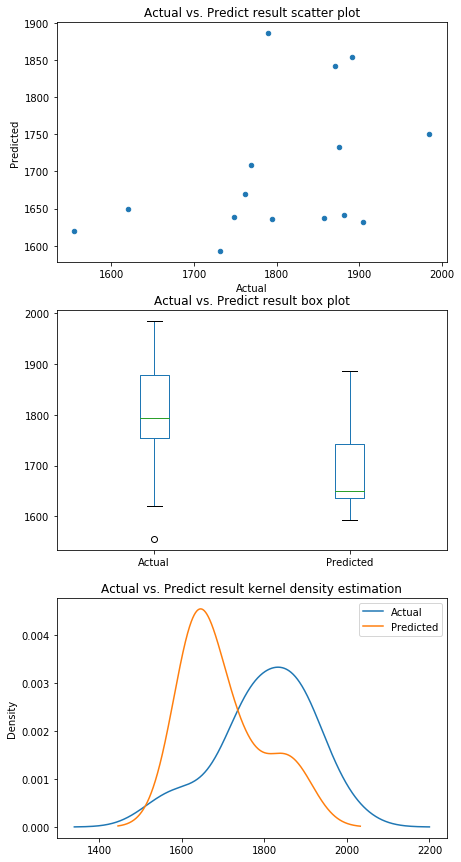

In [54]:
visualize_graph(df_pred_ANN_i)

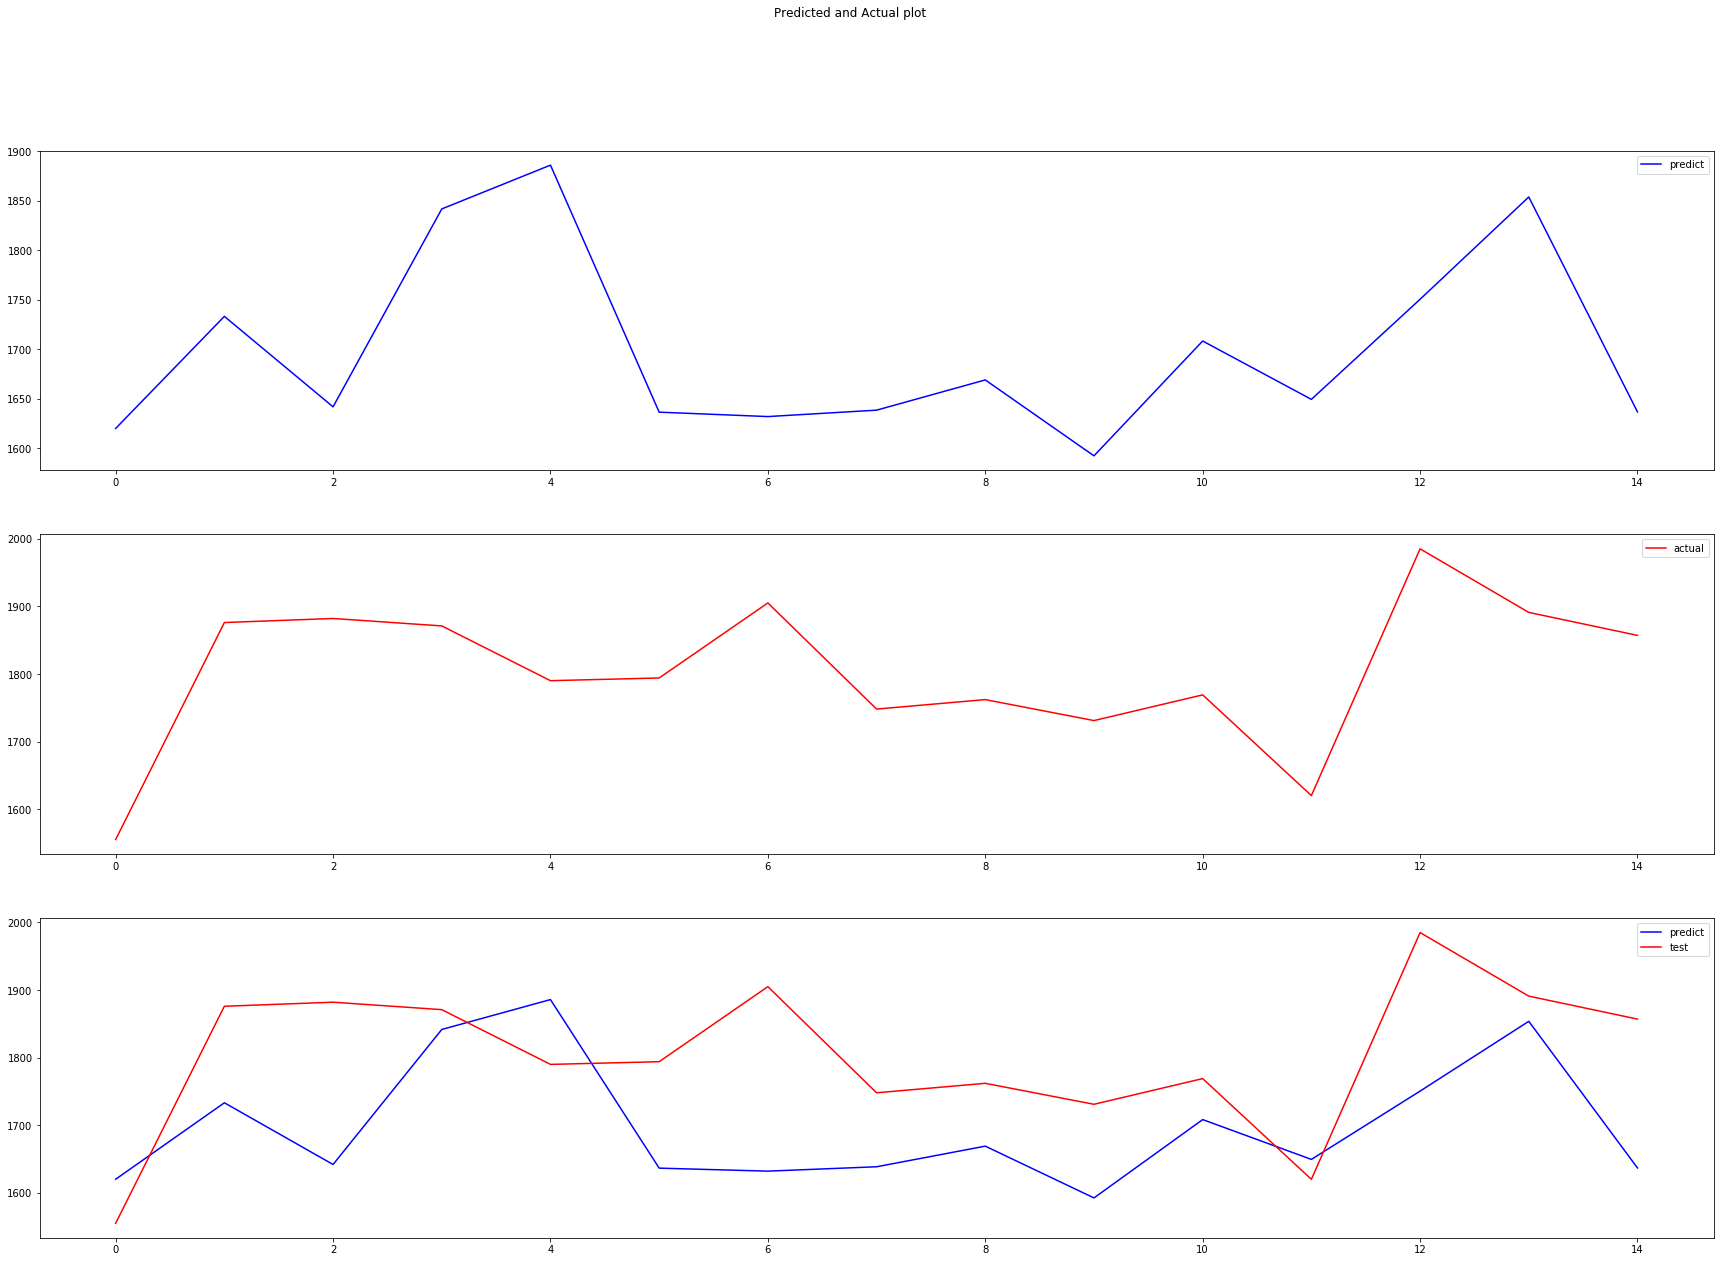

In [55]:
visualization(df_pred_ANN_i.Actual, df_pred_ANN_i.Predicted)

## Residential Consumption Forecast

In [56]:
df_pred_r=sm_regression(X_train_r, y_train_r, X_test_r, y_test_r)

                            OLS Regression Results                            
Dep. Variable:      Residential_Usage   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     55.90
Date:                Wed, 22 Jul 2020   Prob (F-statistic):           4.32e-22
Time:                        10:51:19   Log-Likelihood:                -326.62
No. Observations:                  57   AIC:                             673.2
Df Residuals:                      47   BIC:                             693.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [57]:
df_pred_r

,Actual,Predicted
572,2184.0,2079.608967
1522,2113.0,2087.810130
2072,1757.0,1748.333570
172,1680.0,1600.474019
2972,2098.0,2084.742492
1222,2235.0,2173.312641
1622,1610.0,1434.137012
272,1753.0,1784.042951
522,1765.0,1837.246579
3072,2030.0,2198.480370


In [58]:
evaluate_performances(df_pred_r['Actual'], df_pred_r['Predicted'])

Performance Evaluation
Mean Absolute Error: 87.45848443734282
Mean Squared Error: 11583.643077982395
Root Mean Squared Error: 107.62733425102749


## Residential_Feature Importance

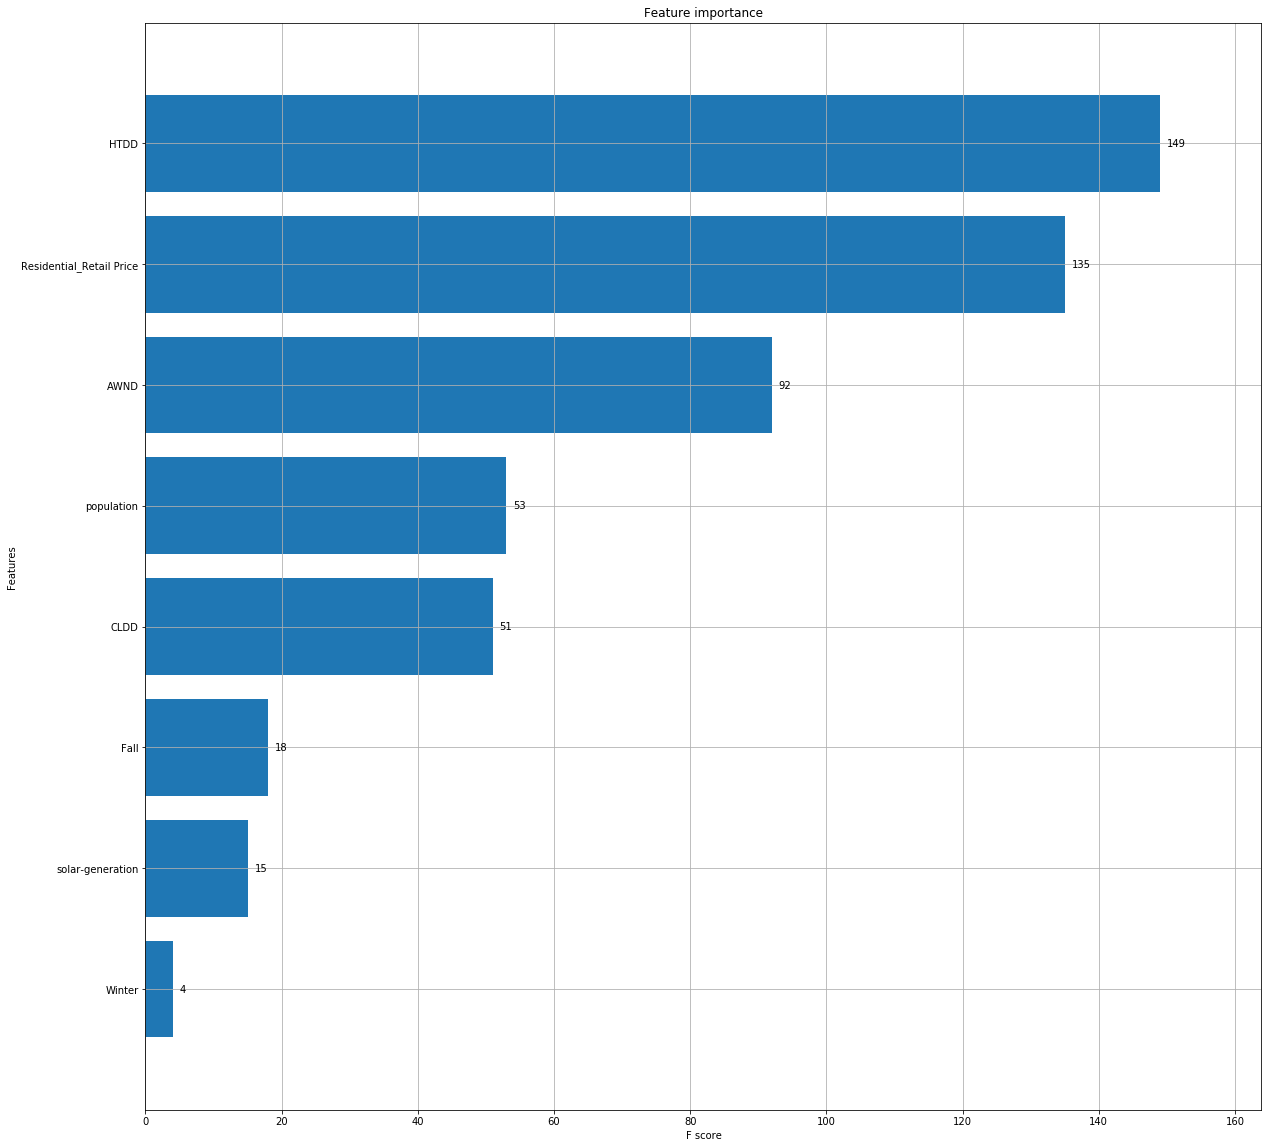

In [59]:
xgbRegressor = XGBRegressor(objective ='reg:squarederror')
xgbRegressor.fit(X_train_r, y_train_r)

fig, ax = plt.subplots(figsize=(20,20))
xgb.plot_importance(xgbRegressor, height=0.8, ax=ax)

C:\Users\Maggie\Anaconda3\envs\tensorflow_env\lib\site-packages\seaborn\axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


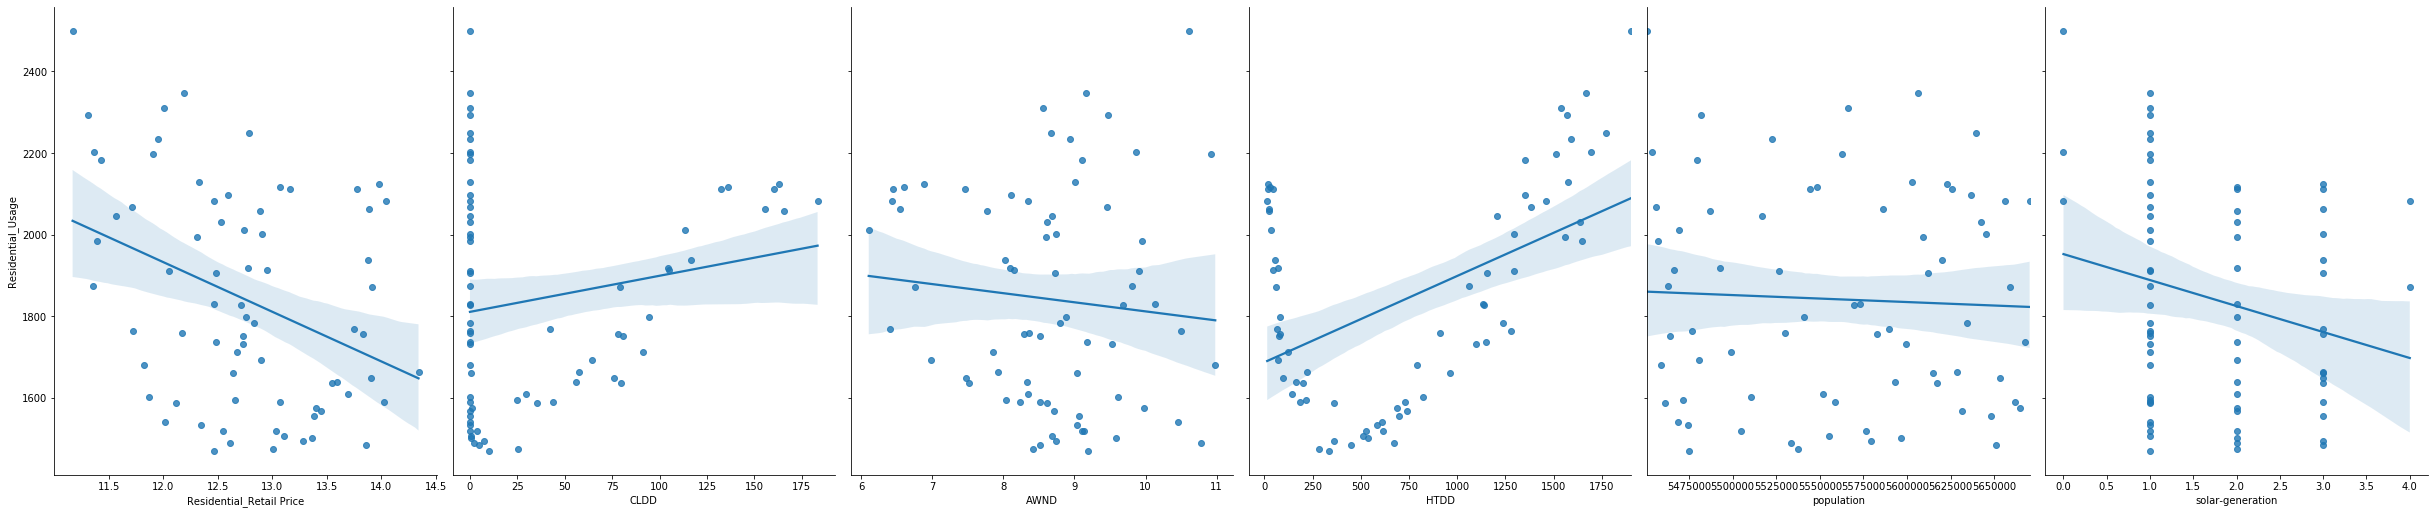

In [60]:
# Correlation Analysis
correlation_analysis(data_MN, residential_numeric_columns_adj, ['Residential_Usage'])

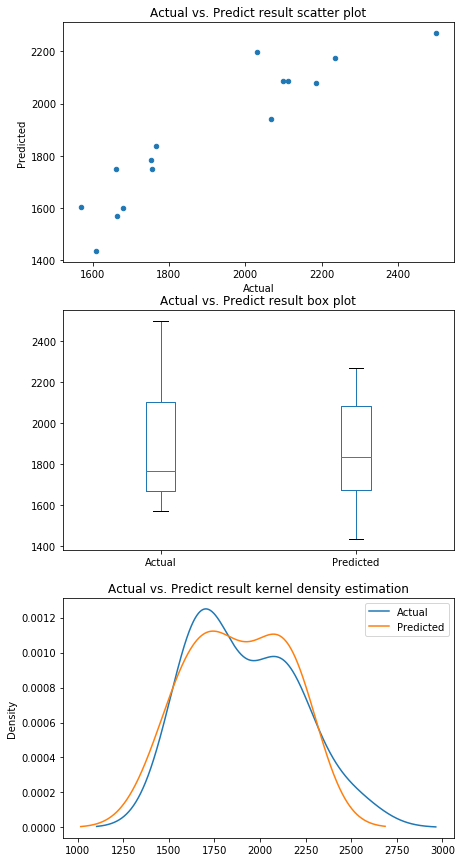

In [61]:
visualize_graph(df_pred_r)

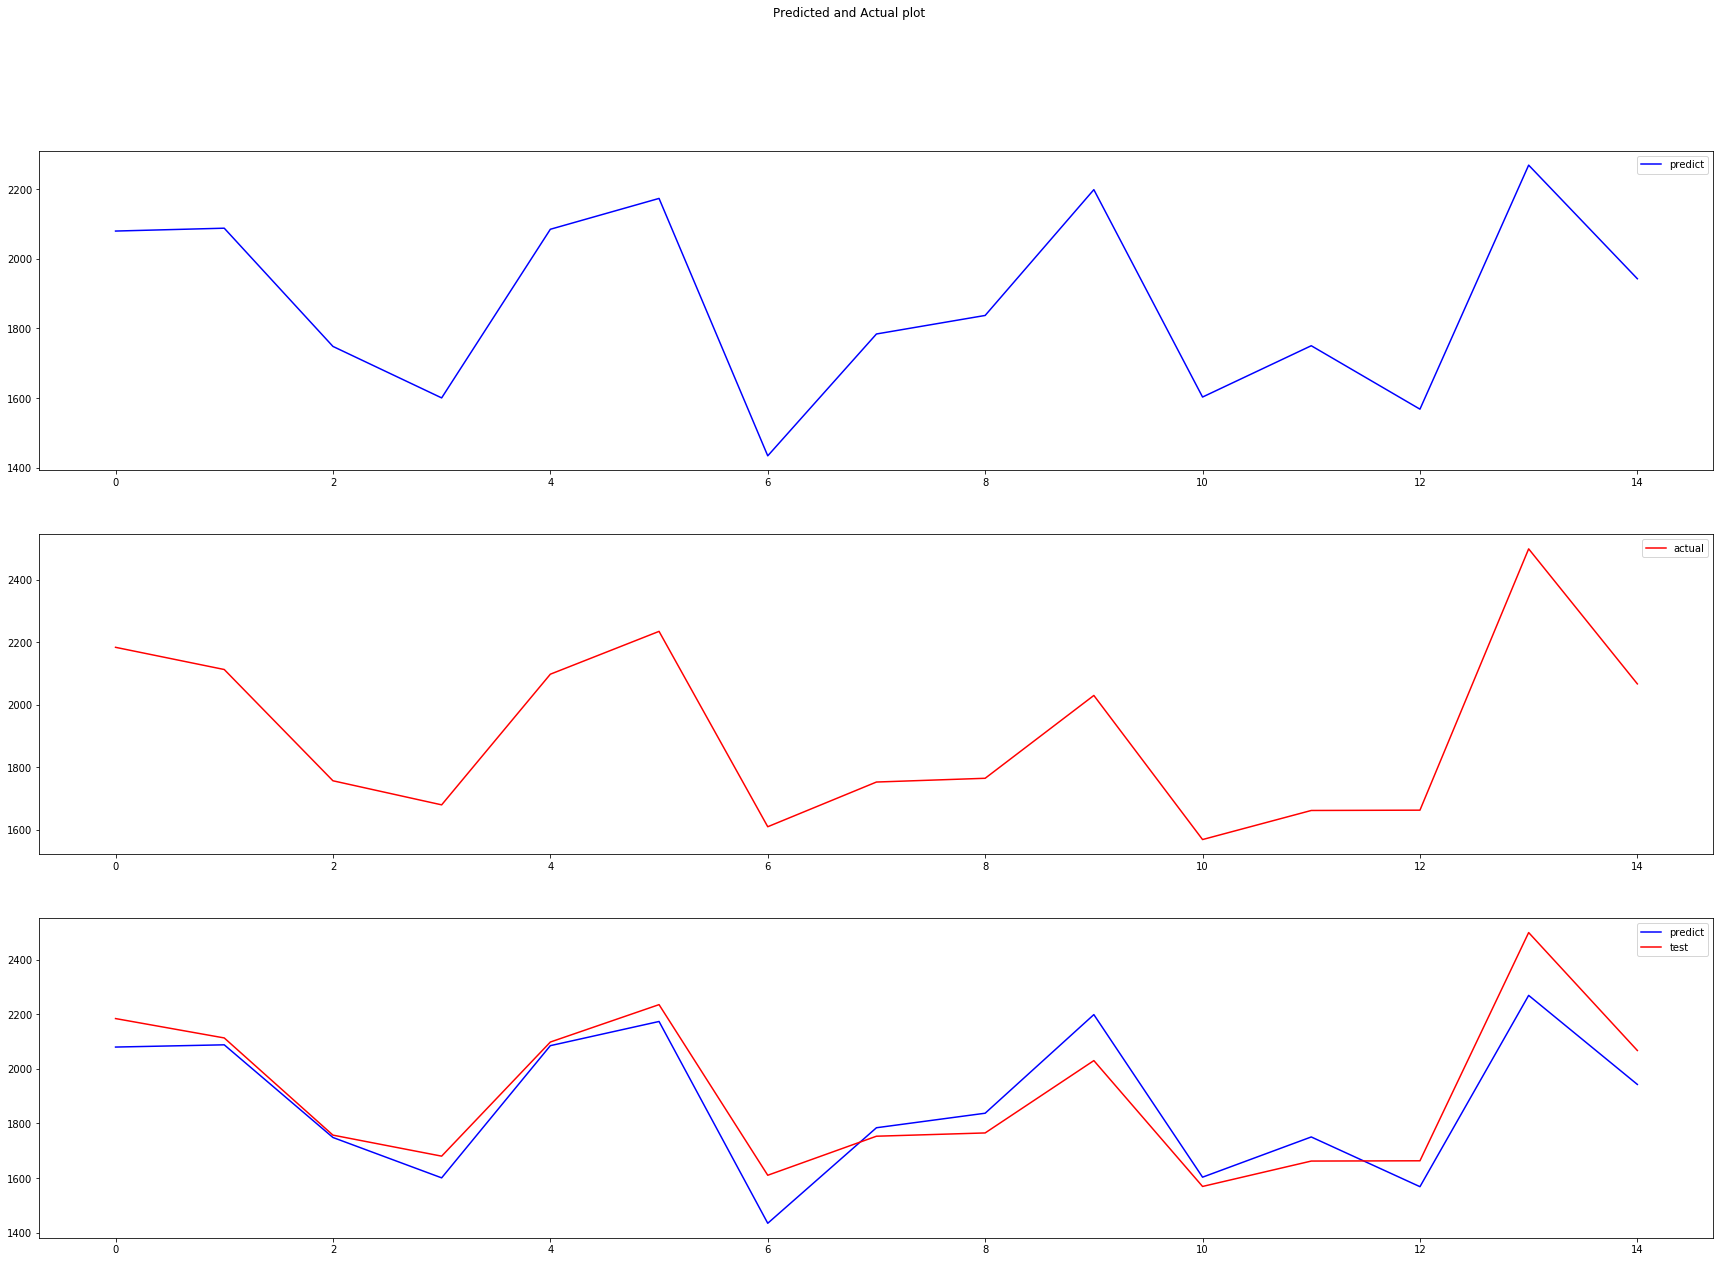

In [62]:
visualization(df_pred_r.Actual, df_pred_r.Predicted)

### Residential_ANN

In [63]:
features_ANN_r=['Month', 'Residential_Usage', 'CLDD', 'AWND', 'HTDD', 'population', 'solar-generation','Summer', 'Fall', 'Winter', 'Residential_Retail Price']
#Spring is the seasonal feature baseline
data_MN_ANN=data[data.MN==1]
data_MN_ANN=data_MN_ANN[features_ANN_r]
data_MN_ANN


,Month,Residential_Usage,CLDD,AWND,HTDD,population,solar-generation,Summer,Fall,Winter,Residential_Retail Price
22,1,2499.0,0.000000,10.618750,1903.577778,5451079,0,0,0,1,11.17
72,2,2202.0,0.000000,9.868750,1691.444444,5453658,0,0,0,1,11.37
122,3,2067.0,0.000000,9.462500,1385.320442,5456238,1,0,0,0,11.71
172,4,1680.0,0.000000,10.981250,793.747253,5458817,1,0,0,0,11.82
222,5,1587.0,35.298343,8.612500,359.988950,5461397,1,0,0,0,12.12
...,...,...,...,...,...,...,...,...,...,...,...
3372,8,1871.0,79.011696,6.756250,60.491228,5659105,4,1,0,0,13.91
3422,9,1591.0,43.847059,8.513333,182.647059,5661887,3,0,1,0,14.02
3472,10,1576.0,1.315789,9.981250,686.678363,5664669,2,0,1,0,13.40
3522,11,1736.0,0.000000,9.180000,1150.634286,5667451,2,0,1,0,12.48


In [64]:
train_ANN, test_ANN = train_test_split(data_MN_ANN, test_size=0.2)
X_train_ANN_r, y_train_ANN_r = x_y_split(train_ANN, 'Residential_Usage', ['Residential_Usage'])
X_test_ANN_r,y_test_ANN_r = x_y_split(test_ANN, 'Residential_Usage', ['Residential_Usage'])


In [65]:
X_train_ANN_r, X_test_ANN_r = minmax_scaler(X_train_ANN_r, X_test_ANN_r, residential_numeric_columns_adj)
y_train_ANN_r = (y_train_ANN_r - min(y_train_ANN_r))/(max(y_train_ANN_r) - min(y_train_ANN_r))


In [66]:
# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 15, kernel_initializer = 'uniform', activation = 'relu', input_dim = 10))

# Adding the second hidden layer
# classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the second hidden layer
classifier.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae'])

# Fitting the ANN to the training set
classifier.fit(X_train_ANN_r, y_train_ANN_r, validation_split = 0.2, batch_size = 8, epochs = 1200)


Train on 45 samples, validate on 12 samples
Epoch 1/1200
45/45 [==============================] - 1s 21ms/step - loss: 0.0935 - mae: 0.2647 - val_loss: 0.0709 - val_mae: 0.2308
Epoch 2/1200
45/45 [==============================] - 0s 577us/step - loss: 0.0930 - mae: 0.2643 - val_loss: 0.0705 - val_mae: 0.2301
Epoch 3/1200
45/45 [==============================] - 0s 598us/step - loss: 0.0927 - mae: 0.2640 - val_loss: 0.0701 - val_mae: 0.2295
Epoch 4/1200
45/45 [==============================] - 0s 599us/step - loss: 0.0923 - mae: 0.2637 - val_loss: 0.0697 - val_mae: 0.2289
Epoch 5/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0920 - mae: 0.2634 - val_loss: 0.0693 - val_mae: 0.2282
Epoch 6/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0916 - mae: 0.2630 - val_loss: 0.0689 - val_mae: 0.2276
Epoch 7/1200
45/45 [==============================] - 0s 555us/step - loss: 0.0913 - mae: 0.2627 - val_loss: 0.0685 - val_mae: 0.2269
Epoch 8/1200
45/45 

45/45 [==============================] - 0s 554us/step - loss: 0.0613 - mae: 0.2169 - val_loss: 0.0509 - val_mae: 0.1941
Epoch 62/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0610 - mae: 0.2162 - val_loss: 0.0508 - val_mae: 0.1937
Epoch 63/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0606 - mae: 0.2155 - val_loss: 0.0507 - val_mae: 0.1933
Epoch 64/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0603 - mae: 0.2148 - val_loss: 0.0506 - val_mae: 0.1929
Epoch 65/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0600 - mae: 0.2139 - val_loss: 0.0505 - val_mae: 0.1925
Epoch 66/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0596 - mae: 0.2133 - val_loss: 0.0502 - val_mae: 0.1920
Epoch 67/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0593 - mae: 0.2129 - val_loss: 0.0500 - val_mae: 0.1916
Epoch 68/1200
45/45 [==============================] - 0s 510us/step 

45/45 [==============================] - 0s 532us/step - loss: 0.0475 - mae: 0.1910 - val_loss: 0.0397 - val_mae: 0.1755
Epoch 122/1200
45/45 [==============================] - 0s 598us/step - loss: 0.0474 - mae: 0.1907 - val_loss: 0.0396 - val_mae: 0.1754
Epoch 123/1200
45/45 [==============================] - 0s 621us/step - loss: 0.0472 - mae: 0.1904 - val_loss: 0.0392 - val_mae: 0.1752
Epoch 124/1200
45/45 [==============================] - 0s 643us/step - loss: 0.0471 - mae: 0.1900 - val_loss: 0.0390 - val_mae: 0.1749
Epoch 125/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0469 - mae: 0.1896 - val_loss: 0.0389 - val_mae: 0.1747
Epoch 126/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0468 - mae: 0.1892 - val_loss: 0.0390 - val_mae: 0.1747
Epoch 127/1200
45/45 [==============================] - 0s 576us/step - loss: 0.0466 - mae: 0.1888 - val_loss: 0.0389 - val_mae: 0.1746
Epoch 128/1200
45/45 [==============================] - 0s 576u

45/45 [==============================] - 0s 776us/step - loss: 0.0416 - mae: 0.1748 - val_loss: 0.0346 - val_mae: 0.1674
Epoch 182/1200
45/45 [==============================] - 0s 643us/step - loss: 0.0416 - mae: 0.1747 - val_loss: 0.0345 - val_mae: 0.1673
Epoch 183/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0415 - mae: 0.1743 - val_loss: 0.0344 - val_mae: 0.1671
Epoch 184/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0414 - mae: 0.1741 - val_loss: 0.0343 - val_mae: 0.1669
Epoch 185/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0414 - mae: 0.1740 - val_loss: 0.0342 - val_mae: 0.1668
Epoch 186/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0413 - mae: 0.1736 - val_loss: 0.0341 - val_mae: 0.1667
Epoch 187/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0412 - mae: 0.1734 - val_loss: 0.0341 - val_mae: 0.1666
Epoch 188/1200
45/45 [==============================] - 0s 510u

45/45 [==============================] - 0s 555us/step - loss: 0.0391 - mae: 0.1647 - val_loss: 0.0323 - val_mae: 0.1606
Epoch 242/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0391 - mae: 0.1646 - val_loss: 0.0321 - val_mae: 0.1604
Epoch 243/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0390 - mae: 0.1644 - val_loss: 0.0321 - val_mae: 0.1603
Epoch 244/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0390 - mae: 0.1643 - val_loss: 0.0321 - val_mae: 0.1602
Epoch 245/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0390 - mae: 0.1641 - val_loss: 0.0321 - val_mae: 0.1601
Epoch 246/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0389 - mae: 0.1639 - val_loss: 0.0322 - val_mae: 0.1600
Epoch 247/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0389 - mae: 0.1639 - val_loss: 0.0325 - val_mae: 0.1602
Epoch 248/1200
45/45 [==============================] - 0s 511u

45/45 [==============================] - 0s 554us/step - loss: 0.0378 - mae: 0.1586 - val_loss: 0.0313 - val_mae: 0.1545
Epoch 302/1200
45/45 [==============================] - 0s 621us/step - loss: 0.0378 - mae: 0.1587 - val_loss: 0.0314 - val_mae: 0.1544
Epoch 303/1200
45/45 [==============================] - 0s 653us/step - loss: 0.0378 - mae: 0.1587 - val_loss: 0.0313 - val_mae: 0.1542
Epoch 304/1200
45/45 [==============================] - 0s 641us/step - loss: 0.0378 - mae: 0.1584 - val_loss: 0.0314 - val_mae: 0.1543
Epoch 305/1200
45/45 [==============================] - 0s 542us/step - loss: 0.0378 - mae: 0.1584 - val_loss: 0.0314 - val_mae: 0.1543
Epoch 306/1200
45/45 [==============================] - 0s 566us/step - loss: 0.0378 - mae: 0.1584 - val_loss: 0.0314 - val_mae: 0.1543
Epoch 307/1200
45/45 [==============================] - 0s 620us/step - loss: 0.0378 - mae: 0.1582 - val_loss: 0.0312 - val_mae: 0.1540
Epoch 308/1200
45/45 [==============================] - 0s 554u

45/45 [==============================] - 0s 621us/step - loss: 0.0372 - mae: 0.1548 - val_loss: 0.0306 - val_mae: 0.1506
Epoch 362/1200
45/45 [==============================] - 0s 643us/step - loss: 0.0372 - mae: 0.1548 - val_loss: 0.0307 - val_mae: 0.1507
Epoch 363/1200
45/45 [==============================] - 0s 643us/step - loss: 0.0372 - mae: 0.1552 - val_loss: 0.0308 - val_mae: 0.1508
Epoch 364/1200
45/45 [==============================] - 0s 665us/step - loss: 0.0372 - mae: 0.1550 - val_loss: 0.0308 - val_mae: 0.1507
Epoch 365/1200
45/45 [==============================] - 0s 576us/step - loss: 0.0372 - mae: 0.1549 - val_loss: 0.0307 - val_mae: 0.1506
Epoch 366/1200
45/45 [==============================] - 0s 665us/step - loss: 0.0372 - mae: 0.1548 - val_loss: 0.0306 - val_mae: 0.1504
Epoch 367/1200
45/45 [==============================] - 0s 621us/step - loss: 0.0371 - mae: 0.1547 - val_loss: 0.0306 - val_mae: 0.1504
Epoch 368/1200
45/45 [==============================] - 0s 576u

45/45 [==============================] - 0s 554us/step - loss: 0.0367 - mae: 0.1524 - val_loss: 0.0301 - val_mae: 0.1464
Epoch 422/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0367 - mae: 0.1523 - val_loss: 0.0301 - val_mae: 0.1464
Epoch 423/1200
45/45 [==============================] - 0s 576us/step - loss: 0.0367 - mae: 0.1522 - val_loss: 0.0301 - val_mae: 0.1464
Epoch 424/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0367 - mae: 0.1522 - val_loss: 0.0301 - val_mae: 0.1462
Epoch 425/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0367 - mae: 0.1521 - val_loss: 0.0300 - val_mae: 0.1461
Epoch 426/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0367 - mae: 0.1521 - val_loss: 0.0299 - val_mae: 0.1459
Epoch 427/1200
45/45 [==============================] - 0s 598us/step - loss: 0.0367 - mae: 0.1521 - val_loss: 0.0299 - val_mae: 0.1458
Epoch 428/1200
45/45 [==============================] - 0s 665u

45/45 [==============================] - 0s 576us/step - loss: 0.0355 - mae: 0.1478 - val_loss: 0.0300 - val_mae: 0.1454
Epoch 482/1200
45/45 [==============================] - 0s 576us/step - loss: 0.0354 - mae: 0.1472 - val_loss: 0.0301 - val_mae: 0.1463
Epoch 483/1200
45/45 [==============================] - 0s 576us/step - loss: 0.0354 - mae: 0.1475 - val_loss: 0.0301 - val_mae: 0.1465
Epoch 484/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0354 - mae: 0.1475 - val_loss: 0.0302 - val_mae: 0.1468
Epoch 485/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0354 - mae: 0.1474 - val_loss: 0.0302 - val_mae: 0.1467
Epoch 486/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0354 - mae: 0.1473 - val_loss: 0.0300 - val_mae: 0.1452
Epoch 487/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0353 - mae: 0.1469 - val_loss: 0.0300 - val_mae: 0.1454
Epoch 488/1200
45/45 [==============================] - 0s 510u

45/45 [==============================] - 0s 709us/step - loss: 0.0347 - mae: 0.1429 - val_loss: 0.0298 - val_mae: 0.1431
Epoch 542/1200
45/45 [==============================] - 0s 687us/step - loss: 0.0347 - mae: 0.1431 - val_loss: 0.0298 - val_mae: 0.1438
Epoch 543/1200
45/45 [==============================] - 0s 731us/step - loss: 0.0347 - mae: 0.1432 - val_loss: 0.0299 - val_mae: 0.1446
Epoch 544/1200
45/45 [==============================] - 0s 731us/step - loss: 0.0347 - mae: 0.1432 - val_loss: 0.0298 - val_mae: 0.1440
Epoch 545/1200
45/45 [==============================] - 0s 731us/step - loss: 0.0347 - mae: 0.1433 - val_loss: 0.0297 - val_mae: 0.1424
Epoch 546/1200
45/45 [==============================] - 0s 731us/step - loss: 0.0347 - mae: 0.1428 - val_loss: 0.0297 - val_mae: 0.1424
Epoch 547/1200
45/45 [==============================] - 0s 665us/step - loss: 0.0347 - mae: 0.1428 - val_loss: 0.0298 - val_mae: 0.1428
Epoch 548/1200
45/45 [==============================] - 0s 665u

45/45 [==============================] - 0s 554us/step - loss: 0.0345 - mae: 0.1407 - val_loss: 0.0301 - val_mae: 0.1422
Epoch 602/1200
45/45 [==============================] - 0s 598us/step - loss: 0.0344 - mae: 0.1400 - val_loss: 0.0300 - val_mae: 0.1425
Epoch 603/1200
45/45 [==============================] - 0s 643us/step - loss: 0.0345 - mae: 0.1402 - val_loss: 0.0300 - val_mae: 0.1429
Epoch 604/1200
45/45 [==============================] - 0s 997us/step - loss: 0.0345 - mae: 0.1395 - val_loss: 0.0300 - val_mae: 0.1427
Epoch 605/1200
45/45 [==============================] - 0s 754us/step - loss: 0.0344 - mae: 0.1399 - val_loss: 0.0301 - val_mae: 0.1426
Epoch 606/1200
45/45 [==============================] - 0s 754us/step - loss: 0.0344 - mae: 0.1402 - val_loss: 0.0301 - val_mae: 0.1426
Epoch 607/1200
45/45 [==============================] - 0s 776us/step - loss: 0.0344 - mae: 0.1400 - val_loss: 0.0301 - val_mae: 0.1428
Epoch 608/1200
45/45 [==============================] - 0s 643u

45/45 [==============================] - 0s 643us/step - loss: 0.0344 - mae: 0.1388 - val_loss: 0.0303 - val_mae: 0.1454
Epoch 662/1200
45/45 [==============================] - 0s 643us/step - loss: 0.0344 - mae: 0.1384 - val_loss: 0.0303 - val_mae: 0.1453
Epoch 663/1200
45/45 [==============================] - 0s 621us/step - loss: 0.0344 - mae: 0.1387 - val_loss: 0.0303 - val_mae: 0.1452
Epoch 664/1200
45/45 [==============================] - 0s 709us/step - loss: 0.0344 - mae: 0.1390 - val_loss: 0.0304 - val_mae: 0.1452
Epoch 665/1200
45/45 [==============================] - 0s 598us/step - loss: 0.0344 - mae: 0.1387 - val_loss: 0.0303 - val_mae: 0.1454
Epoch 666/1200
45/45 [==============================] - ETA: 0s - loss: 0.0470 - mae: 0.151 - 0s 621us/step - loss: 0.0344 - mae: 0.1384 - val_loss: 0.0303 - val_mae: 0.1455
Epoch 667/1200
45/45 [==============================] - 0s 643us/step - loss: 0.0344 - mae: 0.1384 - val_loss: 0.0303 - val_mae: 0.1455
Epoch 668/1200
45/45 [===

Epoch 721/1200
45/45 [==============================] - 0s 754us/step - loss: 0.0343 - mae: 0.1379 - val_loss: 0.0305 - val_mae: 0.1465
Epoch 722/1200
45/45 [==============================] - 0s 643us/step - loss: 0.0343 - mae: 0.1382 - val_loss: 0.0305 - val_mae: 0.1465
Epoch 723/1200
45/45 [==============================] - 0s 665us/step - loss: 0.0344 - mae: 0.1382 - val_loss: 0.0305 - val_mae: 0.1467
Epoch 724/1200
45/45 [==============================] - 0s 643us/step - loss: 0.0343 - mae: 0.1379 - val_loss: 0.0305 - val_mae: 0.1466
Epoch 725/1200
45/45 [==============================] - 0s 709us/step - loss: 0.0343 - mae: 0.1381 - val_loss: 0.0305 - val_mae: 0.1466
Epoch 726/1200
45/45 [==============================] - 0s 687us/step - loss: 0.0343 - mae: 0.1383 - val_loss: 0.0305 - val_mae: 0.1465
Epoch 727/1200
45/45 [==============================] - 0s 665us/step - loss: 0.0343 - mae: 0.1382 - val_loss: 0.0305 - val_mae: 0.1467
Epoch 728/1200
45/45 [==========================

Epoch 781/1200
45/45 [==============================] - 0s 842us/step - loss: 0.0343 - mae: 0.1377 - val_loss: 0.0306 - val_mae: 0.1473
Epoch 782/1200
45/45 [==============================] - 0s 842us/step - loss: 0.0343 - mae: 0.1377 - val_loss: 0.0306 - val_mae: 0.1471
Epoch 783/1200
45/45 [==============================] - 0s 820us/step - loss: 0.0343 - mae: 0.1379 - val_loss: 0.0306 - val_mae: 0.1471
Epoch 784/1200
45/45 [==============================] - 0s 798us/step - loss: 0.0343 - mae: 0.1378 - val_loss: 0.0306 - val_mae: 0.1471
Epoch 785/1200
45/45 [==============================] - 0s 820us/step - loss: 0.0343 - mae: 0.1380 - val_loss: 0.0306 - val_mae: 0.1471
Epoch 786/1200
45/45 [==============================] - 0s 754us/step - loss: 0.0343 - mae: 0.1378 - val_loss: 0.0306 - val_mae: 0.1473
Epoch 787/1200
45/45 [==============================] - 0s 753us/step - loss: 0.0343 - mae: 0.1380 - val_loss: 0.0306 - val_mae: 0.1472
Epoch 788/1200
45/45 [==========================

Epoch 841/1200
45/45 [==============================] - 0s 687us/step - loss: 0.0343 - mae: 0.1376 - val_loss: 0.0307 - val_mae: 0.1474
Epoch 842/1200
45/45 [==============================] - 0s 621us/step - loss: 0.0343 - mae: 0.1377 - val_loss: 0.0307 - val_mae: 0.1474
Epoch 843/1200
45/45 [==============================] - 0s 687us/step - loss: 0.0343 - mae: 0.1375 - val_loss: 0.0307 - val_mae: 0.1476
Epoch 844/1200
45/45 [==============================] - 0s 621us/step - loss: 0.0343 - mae: 0.1374 - val_loss: 0.0307 - val_mae: 0.1476
Epoch 845/1200
45/45 [==============================] - 0s 643us/step - loss: 0.0343 - mae: 0.1374 - val_loss: 0.0307 - val_mae: 0.1476
Epoch 846/1200
45/45 [==============================] - 0s 665us/step - loss: 0.0343 - mae: 0.1374 - val_loss: 0.0307 - val_mae: 0.1476
Epoch 847/1200
45/45 [==============================] - 0s 621us/step - loss: 0.0343 - mae: 0.1373 - val_loss: 0.0307 - val_mae: 0.1475
Epoch 848/1200
45/45 [==========================

45/45 [==============================] - 0s 576us/step - loss: 0.0343 - mae: 0.1373 - val_loss: 0.0307 - val_mae: 0.1480
Epoch 902/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0343 - mae: 0.1377 - val_loss: 0.0307 - val_mae: 0.1481
Epoch 903/1200
45/45 [==============================] - 0s 576us/step - loss: 0.0343 - mae: 0.1376 - val_loss: 0.0307 - val_mae: 0.1473
Epoch 904/1200
45/45 [==============================] - 0s 576us/step - loss: 0.0343 - mae: 0.1384 - val_loss: 0.0307 - val_mae: 0.1474
Epoch 905/1200
45/45 [==============================] - 0s 621us/step - loss: 0.0343 - mae: 0.1378 - val_loss: 0.0307 - val_mae: 0.1479
Epoch 906/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0343 - mae: 0.1378 - val_loss: 0.0307 - val_mae: 0.1481
Epoch 907/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0343 - mae: 0.1377 - val_loss: 0.0307 - val_mae: 0.1474
Epoch 908/1200
45/45 [==============================] - 0s 564u

45/45 [==============================] - 0s 488us/step - loss: 0.0343 - mae: 0.1376 - val_loss: 0.0307 - val_mae: 0.1482
Epoch 962/1200
45/45 [==============================] - 0s 643us/step - loss: 0.0343 - mae: 0.1375 - val_loss: 0.0307 - val_mae: 0.1481
Epoch 963/1200
45/45 [==============================] - 0s 731us/step - loss: 0.0343 - mae: 0.1374 - val_loss: 0.0307 - val_mae: 0.1483
Epoch 964/1200
45/45 [==============================] - 0s 687us/step - loss: 0.0343 - mae: 0.1373 - val_loss: 0.0307 - val_mae: 0.1480
Epoch 965/1200
45/45 [==============================] - 0s 687us/step - loss: 0.0343 - mae: 0.1374 - val_loss: 0.0307 - val_mae: 0.1479
Epoch 966/1200
45/45 [==============================] - 0s 798us/step - loss: 0.0343 - mae: 0.1375 - val_loss: 0.0307 - val_mae: 0.1481
Epoch 967/1200
45/45 [==============================] - 0s 798us/step - loss: 0.0343 - mae: 0.1373 - val_loss: 0.0307 - val_mae: 0.1480
Epoch 968/1200
45/45 [==============================] - 0s 864u

45/45 [==============================] - 0s 576us/step - loss: 0.0343 - mae: 0.1381 - val_loss: 0.0308 - val_mae: 0.1479
Epoch 1022/1200
45/45 [==============================] - 0s 709us/step - loss: 0.0343 - mae: 0.1376 - val_loss: 0.0308 - val_mae: 0.1484
Epoch 1023/1200
45/45 [==============================] - 0s 665us/step - loss: 0.0343 - mae: 0.1375 - val_loss: 0.0308 - val_mae: 0.1481
Epoch 1024/1200
45/45 [==============================] - 0s 754us/step - loss: 0.0343 - mae: 0.1372 - val_loss: 0.0308 - val_mae: 0.1481
Epoch 1025/1200
45/45 [==============================] - 0s 598us/step - loss: 0.0343 - mae: 0.1373 - val_loss: 0.0308 - val_mae: 0.1482
Epoch 1026/1200
45/45 [==============================] - 0s 576us/step - loss: 0.0343 - mae: 0.1373 - val_loss: 0.0308 - val_mae: 0.1479
Epoch 1027/1200
45/45 [==============================] - 0s 643us/step - loss: 0.0343 - mae: 0.1376 - val_loss: 0.0308 - val_mae: 0.1481
Epoch 1028/1200
45/45 [==============================] - 

Epoch 1081/1200
45/45 [==============================] - 0s 576us/step - loss: 0.0343 - mae: 0.1371 - val_loss: 0.0309 - val_mae: 0.1483
Epoch 1082/1200
45/45 [==============================] - 0s 621us/step - loss: 0.0343 - mae: 0.1372 - val_loss: 0.0309 - val_mae: 0.1485
Epoch 1083/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0342 - mae: 0.1369 - val_loss: 0.0309 - val_mae: 0.1486
Epoch 1084/1200
45/45 [==============================] - 0s 576us/step - loss: 0.0343 - mae: 0.1370 - val_loss: 0.0308 - val_mae: 0.1486
Epoch 1085/1200
45/45 [==============================] - 0s 576us/step - loss: 0.0342 - mae: 0.1370 - val_loss: 0.0309 - val_mae: 0.1484
Epoch 1086/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0342 - mae: 0.1370 - val_loss: 0.0309 - val_mae: 0.1484
Epoch 1087/1200
45/45 [==============================] - 0s 576us/step - loss: 0.0343 - mae: 0.1379 - val_loss: 0.0309 - val_mae: 0.1481
Epoch 1088/1200
45/45 [==================

Epoch 1141/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0342 - mae: 0.1371 - val_loss: 0.0309 - val_mae: 0.1486
Epoch 1142/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0342 - mae: 0.1369 - val_loss: 0.0309 - val_mae: 0.1490
Epoch 1143/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0343 - mae: 0.1371 - val_loss: 0.0309 - val_mae: 0.1488
Epoch 1144/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0342 - mae: 0.1368 - val_loss: 0.0309 - val_mae: 0.1486
Epoch 1145/1200
45/45 [==============================] - 0s 487us/step - loss: 0.0342 - mae: 0.1369 - val_loss: 0.0309 - val_mae: 0.1487
Epoch 1146/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0343 - mae: 0.1372 - val_loss: 0.0309 - val_mae: 0.1489
Epoch 1147/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0342 - mae: 0.1369 - val_loss: 0.0309 - val_mae: 0.1486
Epoch 1148/1200
45/45 [==================

In [67]:
# Predicting the Test set results
predictions_ANN_r = classifier.predict(X_test_ANN_r)
# Scale y back 
predictions_ANN_r = (predictions_ANN_r * (max(y_test_ANN_r) - min(y_test_ANN_r))) + min(y_test_ANN_r)
predictions_ANN_r = predictions_ANN_r.reshape(-1)
df_pred_ANN_r = pd.DataFrame({'Actual': y_test_ANN_r, 'Predicted': predictions_ANN_r})


In [68]:
df_pred_ANN_r

,Actual,Predicted
1522,2113.0,1682.039307
2722,2125.0,1682.039307
3422,1591.0,1682.039307
722,1874.0,1853.357300
1472,1799.0,1682.039307
2522,1907.0,1799.252441
1772,2199.0,1682.039307
2222,1639.0,1682.039307
1922,1831.0,1870.096802
672,1985.0,1934.656006


In [69]:
evaluate_performances(y_test_ANN_r, predictions_ANN_r)

Performance Evaluation
Mean Absolute Error: 202.852783203125
Mean Squared Error: 71101.74463890592
Root Mean Squared Error: 266.6491039529402


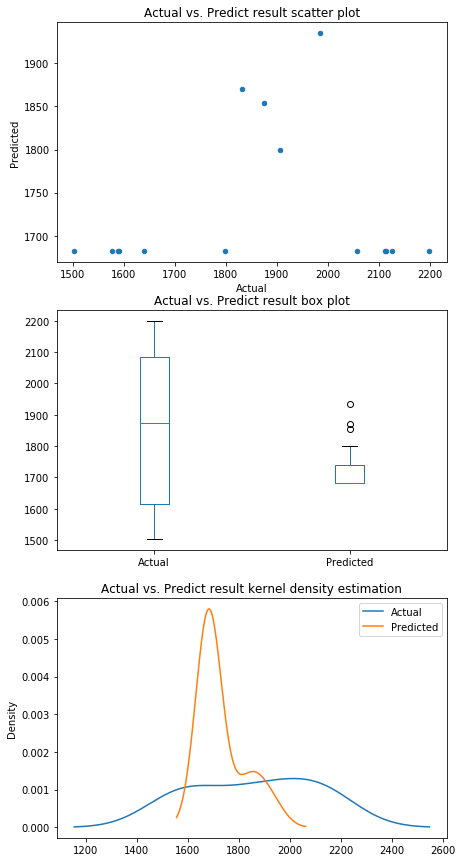

In [70]:
visualize_graph(df_pred_ANN_r)

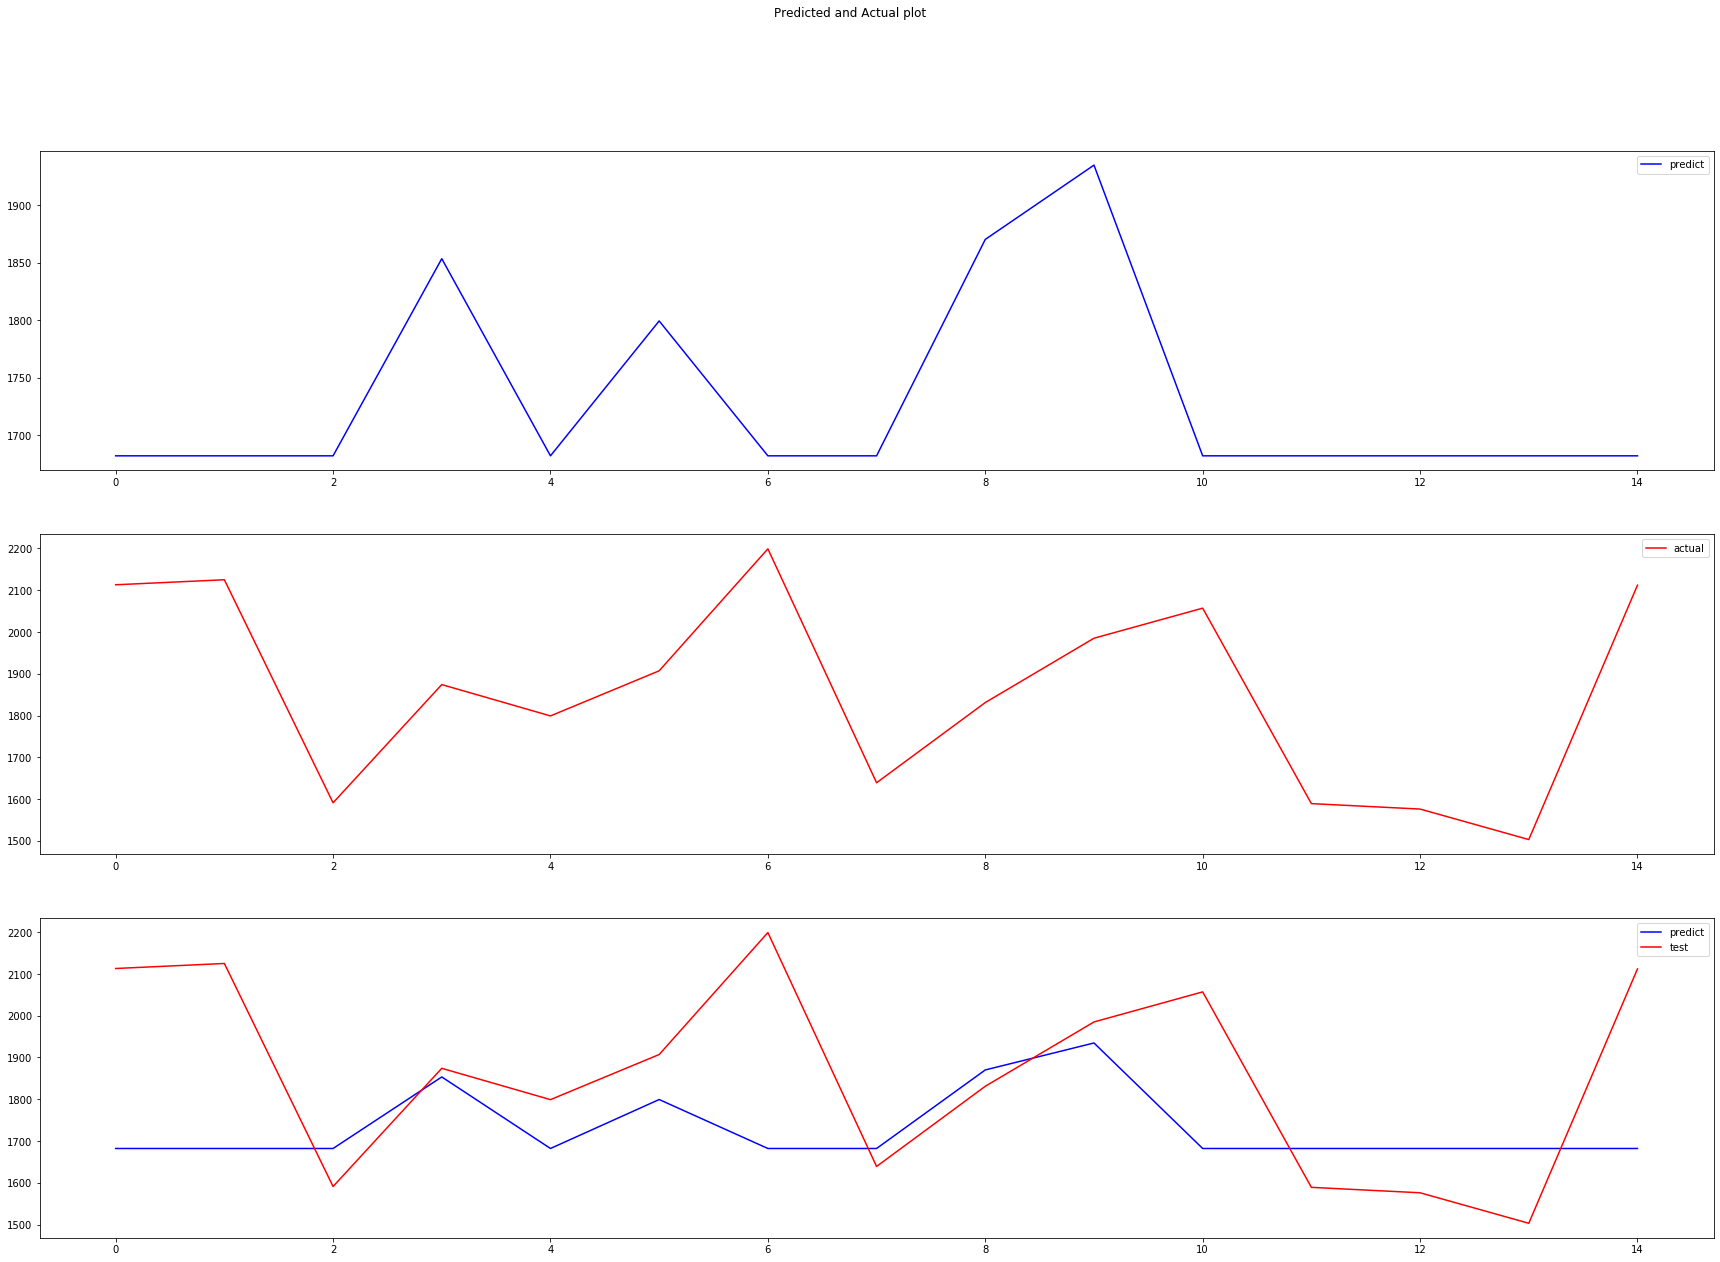

In [71]:
visualization(df_pred_ANN_r.Actual, df_pred_ANN_r.Predicted)